# RESEARCH QUESTION: Consumption forecasting.
We can use the weather forecast for the same day, but consumnption forecasting stops 5 days in advance.

It is said that the forecase is made at around 10 am., but considering the rest of the information we assume the following:

If the forecast is made for the 19th we can use the hourly consumption until 23:59 the 13th.

**Explain methods used in pipeline**
1. Domain understanding
2. Data acquisition
3. Data exploration and visualization
4. Data preprocessing: cleaning, transformation, normalization
5. Feature engineering: construction, selection
6. Model engineering: construction, selection, hyperparameter tuning
7. Evaluation: cross-validation, comparing with baselines

**Time series components:**
- Seasonal
- Trend
- Irregular

This will only be included if we use statistical models.

**Methods:**
- Baseline
- XGBoost (simle input) scrapped, performed poorly
- XGBoost 1 per city
- XGBoost all
- XGBoost all kfold tuned
- RNN: LSTM 1 per city
- RNN: LSTM all
- RNN: Dual-LSTM all 
- RNN: DUal-LSTM all kfold tuned
- Transformer all kfold tuned
- Transformer encoder-only all
- Dual-Transformer all 

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dtype_mapping = {
    'location': 'category',
    'consumption': 'float',
    'temperature': 'float',
}
df = pd.read_csv('data/consumption_temp.csv', dtype=dtype_mapping, parse_dates=['time'])
# set column

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49494 entries, 0 to 49493
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         49494 non-null  datetime64[ns]
 1   location     49494 non-null  category      
 2   consumption  49494 non-null  float64       
 3   temperature  49494 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2)
memory usage: 1.2 MB


In [4]:
df.head()

time   location  consumption  temperature
0 2022-04-07 21:00:00     bergen     1.113325         -0.3
1 2022-04-07 21:00:00       oslo     4.092830          1.0
2 2022-04-07 21:00:00  stavanger     2.057858          1.3
3 2022-04-07 21:00:00     tromsø     1.246582         -3.9
4 2022-04-07 21:00:00  trondheim     1.970098         -2.8

In [5]:
# get counts of each location
df['location'].value_counts()

location
bergen         8641
oslo           8641
stavanger      8641
tromsø         8641
trondheim      8641
helsingfors    6289
Name: count, dtype: int64

In [6]:
# drop location helsingfors
df = df[df['location'] != 'helsingfors']
df['location'] = df['location'].cat.remove_unused_categories()
df['location'].value_counts()

location
bergen       8641
oslo         8641
stavanger    8641
tromsø       8641
trondheim    8641
Name: count, dtype: int64

In [7]:
cities = df['location'].unique()

In [8]:
# explode data based on location
# Pivot for consumption
df_consumption = df.pivot(index='time', columns='location', values='consumption')
df_consumption.columns = [f'{col}_consumption' for col in df_consumption.columns]

# Pivot for temperature
df_temperature = df.pivot(index='time', columns='location', values='temperature')
df_temperature.columns = [f'{col}_temp' for col in df_temperature.columns]

# Merge the two dataframes on time
df_merged = df_consumption.merge(df_temperature, left_index=True, right_index=True)
df_merged.head()

bergen_consumption  oslo_consumption  \
time                                                        
2022-04-07 21:00:00            1.113325          4.092830   
2022-04-07 22:00:00            1.050327          3.818095   
2022-04-07 23:00:00            1.008794          3.660981   
2022-04-08 00:00:00            0.984202          3.584066   
2022-04-08 01:00:00            0.950335          3.549536   

                     stavanger_consumption  tromsø_consumption  \
time                                                             
2022-04-07 21:00:00               2.057858            1.246582   
2022-04-07 22:00:00               1.918996            1.180321   
2022-04-07 23:00:00               1.821749            1.138952   
2022-04-08 00:00:00               1.782011            1.140786   
2022-04-08 01:00:00               1.744253            1.140567   

                     trondheim_consumption  bergen_temp  oslo_temp  \
time                                                                 
2022-04-07 21:00:00               1.970098         -0.3        1.0   
2022-04-07 22:00:00               1.839443          0.0        0.4   
2022-04-07 23:00:00               1.747675         -0.5        0.3   
2022-04-08 00:00:00               1.703176         -1.1        0.2   
2022-04-08 01:00:00               1.694300         -0.7        0.4   

                     stavanger_temp  tromsø_temp  trondheim_temp  
time                                                              
2022-04-07 21:00:00             1.3         -3.9            -2.8  
2022-04-07 22:00:00             0.8         -4.3            -3.3  
2022-04-07 23:00:00             1.1         -5.1            -3.8  
2022-04-08 00:00:00             1.1         -5.7            -4.2  
2022-04-08 01:00:00             1.0         -3.9            -4.1

In [9]:
# add hour column
df_merged['hour'] = df_merged.index.hour
# add weekday column
df_merged['weekday'] = df_merged.index.weekday
df_merged.head()

bergen_consumption  oslo_consumption  \
time                                                        
2022-04-07 21:00:00            1.113325          4.092830   
2022-04-07 22:00:00            1.050327          3.818095   
2022-04-07 23:00:00            1.008794          3.660981   
2022-04-08 00:00:00            0.984202          3.584066   
2022-04-08 01:00:00            0.950335          3.549536   

                     stavanger_consumption  tromsø_consumption  \
time                                                             
2022-04-07 21:00:00               2.057858            1.246582   
2022-04-07 22:00:00               1.918996            1.180321   
2022-04-07 23:00:00               1.821749            1.138952   
2022-04-08 00:00:00               1.782011            1.140786   
2022-04-08 01:00:00               1.744253            1.140567   

                     trondheim_consumption  bergen_temp  oslo_temp  \
time                                                                 
2022-04-07 21:00:00               1.970098         -0.3        1.0   
2022-04-07 22:00:00               1.839443          0.0        0.4   
2022-04-07 23:00:00               1.747675         -0.5        0.3   
2022-04-08 00:00:00               1.703176         -1.1        0.2   
2022-04-08 01:00:00               1.694300         -0.7        0.4   

                     stavanger_temp  tromsø_temp  trondheim_temp  hour  \
time                                                                     
2022-04-07 21:00:00             1.3         -3.9            -2.8    21   
2022-04-07 22:00:00             0.8         -4.3            -3.3    22   
2022-04-07 23:00:00             1.1         -5.1            -3.8    23   
2022-04-08 00:00:00             1.1         -5.7            -4.2     0   
2022-04-08 01:00:00             1.0         -3.9            -4.1     1   

                     weekday  
time                          
2022-04-07 21:00:00        3  
2022-04-07 22:00:00        3  
2022-04-07 23:00:00        3  
2022-04-08 00:00:00        4  
2022-04-08 01:00:00        4

# Pre process

## Standarization

In [10]:
def standardize_data(df):
    # Per location
    # standardize data
    np_df = df.to_numpy()
    for i in range(5):
        # get mean and std for consumption
        consumption_mean = np_df[:, i].mean()
        consumption_std = np_df[:, i].std()

        # get mean and std for temperature
        temp_mean = np_df[:, i+5].mean()
        temp_std = np_df[:, i+5].std()

        # standardize data
        np_df[:, i] = (np_df[:, i] - consumption_mean) / consumption_std
        np_df[:, i+5] = (np_df[:, i+5] - temp_mean) / temp_std
    return np_df

In [11]:
np_df = standardize_data(df_merged)
df = pd.DataFrame(np_df, columns=df_merged.columns, index=df_merged.index)
df.head()

bergen_consumption  oslo_consumption  \
time                                                        
2022-04-07 21:00:00           -0.660391         -0.595758   
2022-04-07 22:00:00           -0.714890         -0.654558   
2022-04-07 23:00:00           -0.750819         -0.688184   
2022-04-08 00:00:00           -0.772093         -0.704646   
2022-04-08 01:00:00           -0.801390         -0.712036   

                     stavanger_consumption  tromsø_consumption  \
time                                                             
2022-04-07 21:00:00              -0.590128           -0.168468   
2022-04-07 22:00:00              -0.655851           -0.286978   
2022-04-07 23:00:00              -0.701877           -0.360968   
2022-04-08 00:00:00              -0.720685           -0.357688   
2022-04-08 01:00:00              -0.738556           -0.358079   

                     trondheim_consumption  bergen_temp  oslo_temp  \
time                                                                 
2022-04-07 21:00:00              -0.271248    -1.227807  -0.728916   
2022-04-07 22:00:00              -0.386136    -1.182052  -0.797328   
2022-04-07 23:00:00              -0.466829    -1.258311  -0.808730   
2022-04-08 00:00:00              -0.505958    -1.349822  -0.820132   
2022-04-08 01:00:00              -0.513762    -1.288814  -0.797328   

                     stavanger_temp  tromsø_temp  trondheim_temp  hour  \
time                                                                     
2022-04-07 21:00:00       -1.241145    -0.930639       -1.183463  21.0   
2022-04-07 22:00:00       -1.326767    -0.980848       -1.249112  22.0   
2022-04-07 23:00:00       -1.275394    -1.081266       -1.314761  23.0   
2022-04-08 00:00:00       -1.275394    -1.156579       -1.367279   0.0   
2022-04-08 01:00:00       -1.292518    -0.930639       -1.354150   1.0   

                     weekday  
time                          
2022-04-07 21:00:00      3.0  
2022-04-07 22:00:00      3.0  
2022-04-07 23:00:00      3.0  
2022-04-08 00:00:00      4.0  
2022-04-08 01:00:00      4.0

<Axes: xlabel='time'>

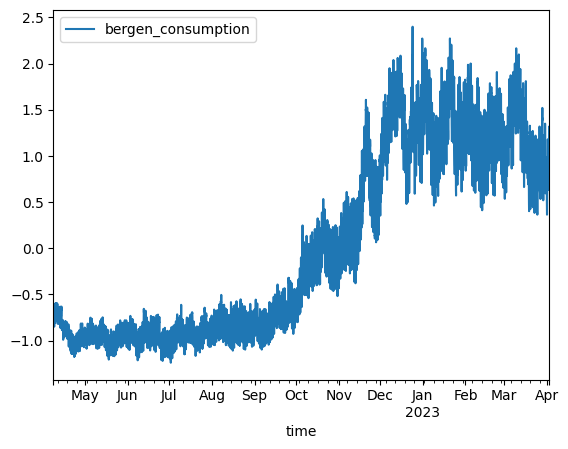

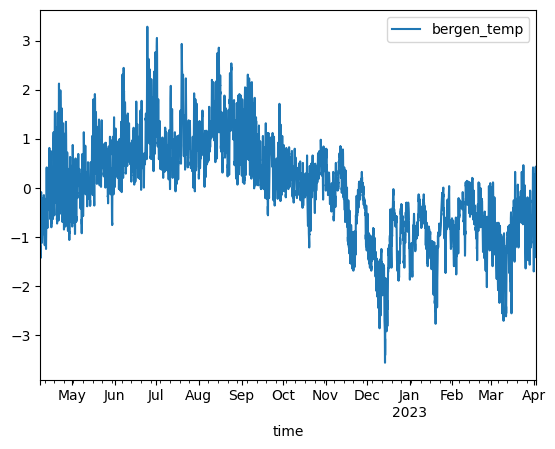

In [12]:
# plot to check if data is standardized
df[['bergen_consumption']].plot()
df[['bergen_temp']].plot()

## Split data

We split the data into training-validation-set and test-set. 
To ensure no leaks we make sure each period does not have overlap.
This however leads to significantly less data than if we would allow for overlap.
Still, we can allow for the test-set to have features from the trainin-validation-set, which makes us able to test on more data or decrease the dedicatedtest-set to train on more data.


To also ensure that the data is varied we split on a cyclic basis to cover seasonality variety in all splits. 
This also leads to even more loss of data... but we believe it is nessecary for the models to see less, but closer data than more data that is further from the same distributions.

It is a pity there is not more data. 1 year is awfully little data and 5 days delay is an awful lot, escpecially when we lose even more y-values due to needing data before. 
Setting up a system to get reliable consumptions hours or just 1 day before forecasts could be looked into. And it could be a possibility to see how that would increase the performance of the models.
However, I suspect that it will be left out.

In [13]:
# create a function to makes splits of the data
# we get time series as output
def split_data(df_, train_val_size, splits):
    # df: df to split
    # train_val_size: size of the training and validation data in float percentage
    # splits: number of splits to make
    train_val = []
    test = []
    split_size = df_.shape[0] // splits
    # loop through the data
    for i in range(splits):
        # get the start and end index of the split
        start = i * split_size
        end = (i + 1) * split_size
        # get the data
        data = df_[start:end]
        # get the train and validation data
        train_val.append(data.index[:int(train_val_size * data.shape[0])])
        # get the test data
        test.append(data.index[int(train_val_size * data.shape[0]):])
    # return the split data
    return np.array(train_val), np.array(test)

In [14]:
# split the data
train_val_times, test_times = split_data(df, 0.8, 3)
train_val_times

array([['2022-04-07T21:00:00.000000000', '2022-04-07T22:00:00.000000000',
        '2022-04-07T23:00:00.000000000', ...,
        '2022-07-12T18:00:00.000000000', '2022-07-12T19:00:00.000000000',
        '2022-07-12T20:00:00.000000000'],
       ['2022-08-05T21:00:00.000000000', '2022-08-05T22:00:00.000000000',
        '2022-08-05T23:00:00.000000000', ...,
        '2022-11-09T18:00:00.000000000', '2022-11-09T19:00:00.000000000',
        '2022-11-09T20:00:00.000000000'],
       ['2022-12-03T21:00:00.000000000', '2022-12-03T22:00:00.000000000',
        '2022-12-03T23:00:00.000000000', ...,
        '2023-03-09T18:00:00.000000000', '2023-03-09T19:00:00.000000000',
        '2023-03-09T20:00:00.000000000']], dtype='datetime64[ns]')

In [15]:
# check the length of each split
train_val_times.shape[1], test_times.shape[1]

(2304, 576)

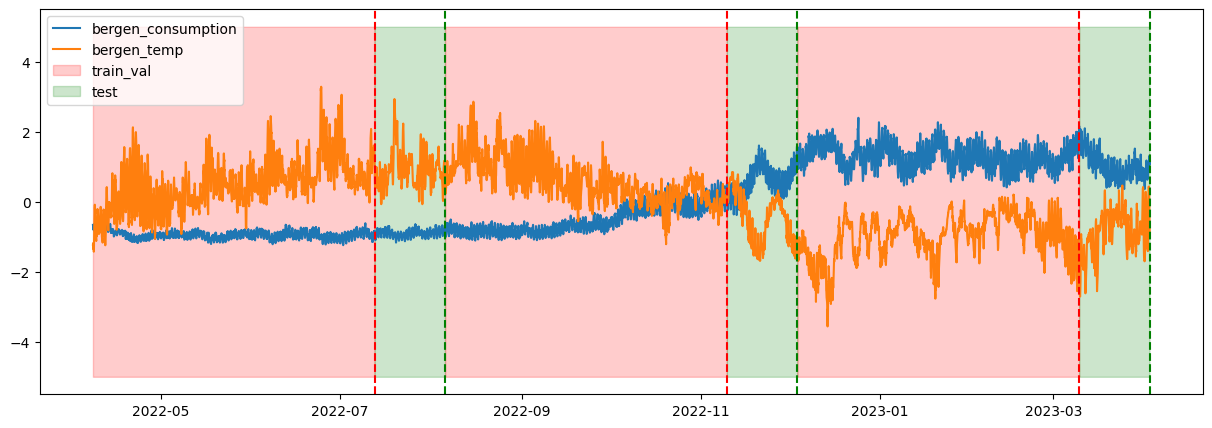

In [16]:
# plot the time splits
def plot_time_splits(city, min_y, max_y, train_val_times, test_times):
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[f'{city}_consumption'], label=f'{city}_consumption')
    plt.plot(df.index, df[f'{city}_temp'], label=f'{city}_temp')

    # Initialize previous period end
    prev_period_end = df.index[0]

    # Alternate between train_val and test times
    for train_period, test_period in zip(train_val_times, test_times):
        # Fill train_val period
        plt.fill_between(df.index, min_y, max_y, where=(df.index >= prev_period_end) & (df.index < train_period[-1]),
                         color='red', alpha=0.2, label='train_val' if prev_period_end == df.index[0] else None)
        # Draw train_val vertical line
        plt.axvline(train_period[-1], color='red', linestyle='--')

        # Fill test period
        plt.fill_between(df.index, min_y, max_y, where=(df.index >= train_period[-1]) & (df.index < test_period[-1]),
                         color='green', alpha=0.2, label='test' if prev_period_end == df.index[0] else None)
        # Draw test vertical line
        plt.axvline(test_period[-1], color='green', linestyle='--')

        # Update previous period end
        prev_period_end = test_period[-1]

    # Handle any remaining train_val period after the last test period
    if len(train_val_times) > len(test_times):
        last_train_period = train_val_times[-1]
        plt.fill_between(df.index, min_y, max_y, where=(df.index >= prev_period_end),
                         color='red', alpha=0.2, label='train_val' if prev_period_end == df.index[0] else None)
        plt.axvline(last_train_period[-1], color='red', linestyle='--')

    # If there are more test periods, handle the last one
    if len(test_times) > len(train_val_times):
        last_test_period = test_times[-1]
        plt.fill_between(df.index, min_y, max_y, where=(df.index >= prev_period_end),
                         color='green', alpha=0.2, label='test' if prev_period_end == df.index[0] else None)
        plt.axvline(last_test_period[-1], color='green', linestyle='--')

    # Add legend
    plt.legend()
    plt.show()
plot_time_splits('bergen', -5, 5, train_val_times, test_times)

# Baseline prediction

In [17]:
def visualize_and_get_metrics(splits, prediction, truth):
    # Setup table to get metrics
    metrics_dict = {'Split': [], 'City': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'MAPE': []}

    # Set up the 3x5 grid of subplots
    fig, axs = plt.subplots(splits, 5, figsize=(20, 12))

    for i in range(splits): # For each split
        for j in range(5):  # For each city
            prediction_ = prediction[i, :, j]
            truth_ = truth[i, :, j]
            axis = np.arange(prediction_.shape[0])
            # Calculate mean absolute error
            mae = np.mean(np.abs(prediction_ - truth_))
            # Calculate mean squared error
            mse = np.mean(np.square(prediction_ - truth_))
            # Calculate root mean squared error
            rmse = np.sqrt(mse)
            # Calculate mean absolute percentage error
            mape = np.mean(np.abs((prediction_ - truth_) / truth_)) * 100

            # Store metrics in the dictionary
            metrics_dict['Split'].append(i+1)
            metrics_dict['City'].append(j+1)
            metrics_dict['MAE'].append(mae)
            metrics_dict['MSE'].append(mse)
            metrics_dict['RMSE'].append(rmse)
            metrics_dict['MAPE'].append(mape)
            
            # Plot the prediction_ and truth_
            ax = axs[i, j]
            ax.plot(axis, truth_, label=f'Groundtruth')
            ax.plot(axis, prediction_, label=f'Prediction')
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            ax.set_title(f'Split {i+1}, City: {cities[j]}')
            ax.legend()

    # Adjust layout so that plots do not overlap
    plt.tight_layout()

    # Display all the plots
    plt.show()

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame(metrics_dict)

    # Calculate the average of the metrics for each city across splits
    avg_metrics_df = metrics_df.groupby('City').mean().reset_index()

    # Display the metrics table
    print("Metrics per City and Split:")
    display(metrics_df)

    # Display the average metrics per city
    print("\nAverage Metrics per City Across Splits:")
    display(avg_metrics_df)

    # Print the overall means
    print(f'\nOverall Mean Metrics:')
    print(f'Mean MAE: {metrics_df["MAE"].mean()}')
    print(f'Mean MSE: {metrics_df["MSE"].mean()}')
    print(f'Mean RMSE: {metrics_df["RMSE"].mean()}')
    print(f'Mean MAPE: {metrics_df["MAPE"].mean()}')

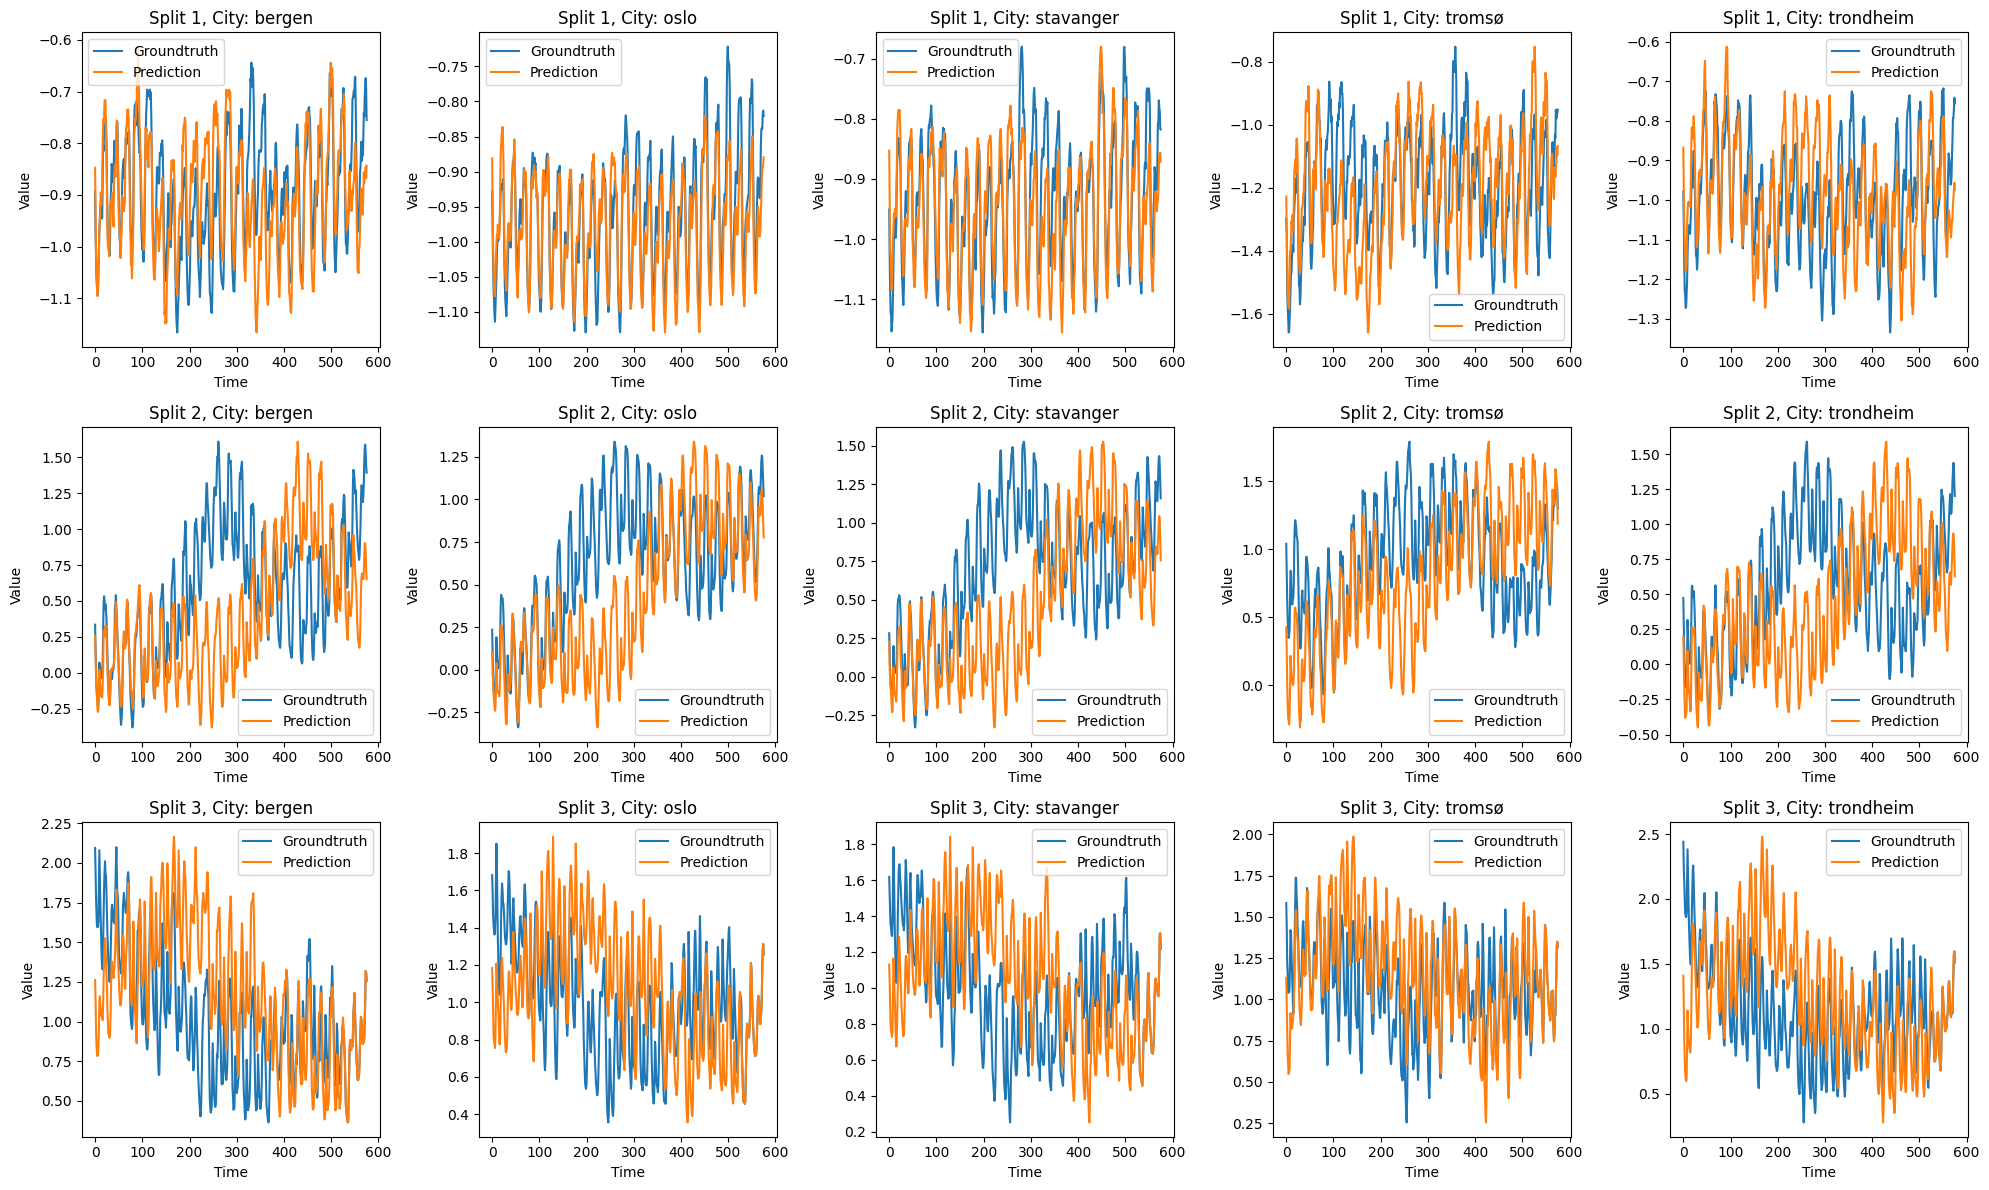

Metrics per City and Split:


Split  City       MAE       MSE      RMSE        MAPE
0       1     1  0.071915  0.007872  0.088722    8.306219
1       1     2  0.032103  0.001743  0.041749    3.478977
2       1     3  0.046135  0.003405  0.058354    5.171929
3       1     4  0.128130  0.023402  0.152976   11.243498
4       1     5  0.097048  0.013264  0.115170    9.998918
5       2     1  0.406581  0.271465  0.521023  120.018026
6       2     2  0.309582  0.168215  0.410140  174.798689
7       2     3  0.389449  0.240358  0.490263   82.899145
8       2     4  0.373034  0.195103  0.441705   59.226029
9       2     5  0.429086  0.276825  0.526142  203.988150
10      3     1  0.332863  0.173518  0.416555   38.674091
11      3     2  0.289474  0.124157  0.352359   33.586215
12      3     3  0.312644  0.141488  0.376149   37.279611
13      3     4  0.219524  0.078015  0.279312   23.538916
14      3     5  0.358011  0.203718  0.451351   35.977946


Average Metrics per City Across Splits:


City  Split       MAE       MSE      RMSE       MAPE
0     1    2.0  0.270453  0.150952  0.342100  55.666112
1     2    2.0  0.210386  0.098038  0.268083  70.621294
2     3    2.0  0.249409  0.128417  0.308255  41.783562
3     4    2.0  0.240229  0.098840  0.291331  31.336147
4     5    2.0  0.294715  0.164602  0.364221  83.321671


Overall Mean Metrics:
Mean MAE: 0.2530385938524258
Mean MSE: 0.1281698975081186
Mean RMSE: 0.31479802545866103
Mean MAPE: 56.54575720896144


In [18]:
# NB: here we use some of the features in the training data for the test data
# get all dates 1 week before test_dates
train_val_dates = np.concatenate(test_times) - pd.Timedelta(days=7)
truth = df.loc[np.concatenate(test_times), df.columns[:5]].to_numpy()
prediction = df.loc[train_val_dates, df.columns[:5]].to_numpy()
# reshape per split
truth = truth.reshape(3, -1, 5)
prediction = prediction.reshape(3, -1, 5)
# visualize the data
visualize_and_get_metrics(3, prediction, truth)

Potential for more here

Interesting note: When using 3 way split the test data for series 1 SUPER similar, but split 2 and 3 is really different. Maybe something to note for the text.

In [19]:
truth.shape, prediction.shape

((3, 576, 5), (3, 576, 5))

# Model 1: Statistical

In [20]:
# 

# Model 2: XGBoost / Tabular

## Setup Tabular

Here we set up the data in a tabular format with lags.

There are so many choices to make here... I have no idea what is good and what is not. The best would be to try all, but there are WAY too many.
Can list some here:
- Should we have all cities data in the same dataset and predict or should we split per city.
- If we split per city should we train one model or all cities or different per city.
- What features should we include, just the relevant hour of prediction with lags or all hours previously (for a period).

If we just include everything we can test for which columns are good, but I give up on trying that...

I tried to include every feature, but it should be fixed now.

### Simple Tabulizer

In [21]:
# Create a dataset with features:
# - time, week_before and week_before2 (only used to validate that the data is correct)
# - split
# - the same hour consumption the two previous weeks
# - the temperature of the two previous weeks
# - the temperature forecast of the hour
# - the hour of the day
# - the day of the week
# - city
# NB: tabulize is probably the wrong word for this exact operation.
def create_feature_dict(df, times, cities, is_train):
    splits = len(times)
    feature_dict = {
        'time_pred' : [],
        'time_week_before' : [],
        'time_week_before2' : [],
        'split': [], 
        'two_week_consumption': [], 
        'one_week_consumption': [], 
        'two_week_temp': [], 
        'one_week_temp': [], 
        'temp_forecast': [],
        'hour': [],
        'weekday': [],
        'city': [],
        'y': []
    }
    # loop through the splits
    for i in range(splits):
        # first for train_val
        for j in range(times[i, 24*15:].shape[0]):
            for k, city in enumerate(cities):
                # for train
                if is_train:
                    time_pred = times[i, j + 14*24]
                else:
                    # for test
                    time_pred = test_times[i, j]
                week_before = time_pred - pd.Timedelta(days=7)
                week_before2 = time_pred - pd.Timedelta(days=14)
                # add split
                feature_dict['split'].append(i)
                # add hour and day of the week
                feature_dict['hour'].append(df.loc[time_pred, 'hour'])
                feature_dict['weekday'].append(df.loc[time_pred, 'weekday'])
                # get the consumption data of the two previous weeks
                feature_dict['two_week_consumption'].append(df.loc[week_before2, f'{city}_consumption'])
                feature_dict['one_week_consumption'].append(df.loc[week_before, f'{city}_consumption'])
                # get target
                feature_dict['y'].append(df.loc[time_pred, f'{city}_consumption'])
                # get the temperature data of the two previous weeks
                feature_dict['two_week_temp'].append(df.loc[week_before2, f'{city}_temp'])
                feature_dict['one_week_temp'].append(df.loc[week_before, f'{city}_temp'])
                # get the temperature forecast of the hour
                feature_dict['temp_forecast'].append(df.loc[time_pred, f'{city}_temp'])
                # add city
                feature_dict['city'].append(k)
                # add time
                feature_dict['time_pred'].append(time_pred)
                feature_dict['time_week_before'].append(week_before)
                feature_dict['time_week_before2'].append(week_before2)

    return feature_dict

def tabulize_data_simple(df, train_val_times, test_times):
    # df: df to tabulize (train_val or test)
    # return: dfs:  train_val, (columns for features, last column is y value)
    #               test, (columns for features, last column is y value)

    # get the train_val data
    train_val_dict = create_feature_dict(df, train_val_times, cities, True)
    # get the test data
    test_dict = create_feature_dict(df, test_times, cities, False)

    # return the dataframes
    return pd.DataFrame(train_val_dict), pd.DataFrame(test_dict)
train_val_tabulized_df, test_tabulized_df = tabulize_data_simple(df, train_val_times, test_times)
train_val_tabulized_df.head()

time_pred    time_week_before   time_week_before2  split  \
0 2022-04-21 21:00:00 2022-04-14 21:00:00 2022-04-07 21:00:00      0   
1 2022-04-21 21:00:00 2022-04-14 21:00:00 2022-04-07 21:00:00      0   
2 2022-04-21 21:00:00 2022-04-14 21:00:00 2022-04-07 21:00:00      0   
3 2022-04-21 21:00:00 2022-04-14 21:00:00 2022-04-07 21:00:00      0   
4 2022-04-21 21:00:00 2022-04-14 21:00:00 2022-04-07 21:00:00      0   

   two_week_consumption  one_week_consumption  two_week_temp  one_week_temp  \
0             -0.660391             -0.852927      -1.227807      -0.068669   
1             -0.595758             -0.775448      -0.728916      -0.512278   
2             -0.590128             -0.774852      -1.241145      -0.693162   
3             -0.168468             -0.520292      -0.930639      -0.252817   
4             -0.271248             -0.645900      -1.183463      -0.632015   

   temp_forecast  hour  weekday  city         y  
0       0.327878  21.0      3.0     0 -0.994897  
1       0.365675  21.0      3.0     1 -0.943791  
2      -0.110931  21.0      3.0     2 -0.936759  
3       0.048437  21.0      3.0     3 -0.602854  
4       0.011341  21.0      3.0     4 -0.733354

In [22]:
df.head()

bergen_consumption  oslo_consumption  \
time                                                        
2022-04-07 21:00:00           -0.660391         -0.595758   
2022-04-07 22:00:00           -0.714890         -0.654558   
2022-04-07 23:00:00           -0.750819         -0.688184   
2022-04-08 00:00:00           -0.772093         -0.704646   
2022-04-08 01:00:00           -0.801390         -0.712036   

                     stavanger_consumption  tromsø_consumption  \
time                                                             
2022-04-07 21:00:00              -0.590128           -0.168468   
2022-04-07 22:00:00              -0.655851           -0.286978   
2022-04-07 23:00:00              -0.701877           -0.360968   
2022-04-08 00:00:00              -0.720685           -0.357688   
2022-04-08 01:00:00              -0.738556           -0.358079   

                     trondheim_consumption  bergen_temp  oslo_temp  \
time                                                                 
2022-04-07 21:00:00              -0.271248    -1.227807  -0.728916   
2022-04-07 22:00:00              -0.386136    -1.182052  -0.797328   
2022-04-07 23:00:00              -0.466829    -1.258311  -0.808730   
2022-04-08 00:00:00              -0.505958    -1.349822  -0.820132   
2022-04-08 01:00:00              -0.513762    -1.288814  -0.797328   

                     stavanger_temp  tromsø_temp  trondheim_temp  hour  \
time                                                                     
2022-04-07 21:00:00       -1.241145    -0.930639       -1.183463  21.0   
2022-04-07 22:00:00       -1.326767    -0.980848       -1.249112  22.0   
2022-04-07 23:00:00       -1.275394    -1.081266       -1.314761  23.0   
2022-04-08 00:00:00       -1.275394    -1.156579       -1.367279   0.0   
2022-04-08 01:00:00       -1.292518    -0.930639       -1.354150   1.0   

                     weekday  
time                          
2022-04-07 21:00:00      3.0  
2022-04-07 22:00:00      3.0  
2022-04-07 23:00:00      3.0  
2022-04-08 00:00:00      4.0  
2022-04-08 01:00:00      4.0

In [23]:
df.to_numpy().shape

(8641, 12)

In [24]:
train_val_times

array([['2022-04-07T21:00:00.000000000', '2022-04-07T22:00:00.000000000',
        '2022-04-07T23:00:00.000000000', ...,
        '2022-07-12T18:00:00.000000000', '2022-07-12T19:00:00.000000000',
        '2022-07-12T20:00:00.000000000'],
       ['2022-08-05T21:00:00.000000000', '2022-08-05T22:00:00.000000000',
        '2022-08-05T23:00:00.000000000', ...,
        '2022-11-09T18:00:00.000000000', '2022-11-09T19:00:00.000000000',
        '2022-11-09T20:00:00.000000000'],
       ['2022-12-03T21:00:00.000000000', '2022-12-03T22:00:00.000000000',
        '2022-12-03T23:00:00.000000000', ...,
        '2023-03-09T18:00:00.000000000', '2023-03-09T19:00:00.000000000',
        '2023-03-09T20:00:00.000000000']], dtype='datetime64[ns]')

In [25]:
train_val_times.shape

(3, 2304)

In [26]:
df.index.get_loc(train_val_times[1, 2])

2882

### All including Tabulizer

In [27]:
import numpy as np
import pandas as pd

# - time, week_before and week_before2 (only used to validate that the data is correct)
# - split
# - the consumption from 2 weeks to 5 days before
# - the temperature of the two previous weeks
# - the temperature forecast of the hour
# - the hour of the day
# - the day of the week
# - city
# - city_number
# - the target value (consumption of the hour)

def create_feature_matrix(df, times, cities, is_train):
    time_index = df.index
    np_df = df.to_numpy()
    num_cities = len(cities)
    num_times = times.shape[1]
    num_splits = times.shape[0]
    offset = 24*14 if is_train else 0
    split_length = num_times - offset

    num_manual_features = 9
    
    # Pre-calculate indexes for consumption and temperature features
    consumption_idxs = np.arange(-2*24*7, -1*24*5) # consumption from 2 weeks to 5 days before
    temp_idxs = np.arange(-2*24*7, 0) # temperature from 2 weeks to 1 hour before
    
    # Pre-allocate feature arrays with the correct size
    num_features = num_manual_features + consumption_idxs.shape[0] + temp_idxs.shape[0] # basic features + consumption and temp for each hour
    features = np.zeros(((split_length) * num_splits * num_cities, num_features), dtype=object)
    # Fill in the feature values
    for split in range(num_splits):
        for i in range(offset, num_times):
            for city_idx, city in enumerate(cities):
                time_pred = times[split, i]
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 0] = times[split, i]
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 1] = times[split, i] - pd.Timedelta(days=7) # alt1
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 2] = time_index[time_index.get_loc(times[split, i]) - 24*14] # alt2
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 3] = split
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 4] = df.loc[time_pred, 'hour']
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 5] = df.loc[time_pred, 'weekday']
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 6] = city
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 7] = city_idx
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), 8] = df.loc[time_pred, f'{city}_consumption']
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), num_manual_features:(num_manual_features+len(consumption_idxs))] = df.loc[time_pred + pd.to_timedelta(consumption_idxs, unit='H'), f'{city}_consumption'].values
                features[(split * split_length * num_cities) + (i - offset + city_idx * split_length), (num_manual_features+len(consumption_idxs)):] = df.loc[time_pred + pd.to_timedelta(temp_idxs, unit='H'), f'{city}_temp'].values
    
    # Reshape the features to a 2D array where each row is a single sample
    features = features.reshape(-1, num_features)
    
    # Create a feature dictionary from the NumPy array
    feature_dict = {
        'time_pred': features[:, 0],
        'time_week_before': features[:, 1],
        'time_week_before2': features[:, 2],
        'split': features[:, 3],
        'hour': features[:, 4],
        'weekday': features[:, 5],
        'city': features[:, 6],
        'city_number' : features[:, 7],
        'y': features[:, 8]
    }
    
    # Add consumption and temperature features
    for h, idx in enumerate(consumption_idxs, start=1):
        feature_dict[f'consumption_{-idx}_hours_before'] = features[:, num_manual_features+h]
    for h, idx in enumerate(temp_idxs, start=1):
        feature_dict[f'temp_{-idx}_hours_before'] = features[:, num_manual_features+h]
    
    return pd.DataFrame(feature_dict)

def tabulize_data(df, train_val_times, test_times, cities):
    train_val_df = create_feature_matrix(df, train_val_times, cities, True)
    test_df = create_feature_matrix(df, test_times, cities, False)
    return train_val_df, test_df

# Example usage
train_val_tabulized_df, test_tabulized_df = tabulize_data(df, train_val_times, test_times, cities)
train_val_tabulized_df

time_pred    time_week_before   time_week_before2 split  hour  \
0     2022-04-21 21:00:00 2022-04-14 21:00:00 2022-04-07 21:00:00     0  21.0   
1     2022-04-21 22:00:00 2022-04-14 22:00:00 2022-04-07 22:00:00     0  22.0   
2     2022-04-21 23:00:00 2022-04-14 23:00:00 2022-04-07 23:00:00     0  23.0   
3     2022-04-22 00:00:00 2022-04-15 00:00:00 2022-04-08 00:00:00     0   0.0   
4     2022-04-22 01:00:00 2022-04-15 01:00:00 2022-04-08 01:00:00     0   1.0   
...                   ...                 ...                 ...   ...   ...   
29515 2023-03-09 16:00:00 2023-03-02 16:00:00 2023-02-23 16:00:00     2  16.0   
29516 2023-03-09 17:00:00 2023-03-02 17:00:00 2023-02-23 17:00:00     2  17.0   
29517 2023-03-09 18:00:00 2023-03-02 18:00:00 2023-02-23 18:00:00     2  18.0   
29518 2023-03-09 19:00:00 2023-03-02 19:00:00 2023-02-23 19:00:00     2  19.0   
29519 2023-03-09 20:00:00 2023-03-02 20:00:00 2023-02-23 20:00:00     2  20.0   

      weekday       city city_number         y consumption_336_hours_before  \
0         3.0     bergen           0 -0.994897                     -0.71489   
1         3.0     bergen           0 -1.061516                    -0.750819   
2         3.0     bergen           0 -1.105746                    -0.772093   
3         4.0     bergen           0 -1.145188                     -0.80139   
4         4.0     bergen           0 -1.131515                    -0.777862   
...       ...        ...         ...       ...                          ...   
29515     3.0  trondheim           4  1.858542                     1.581319   
29516     3.0  trondheim           4  2.000461                     1.563706   
29517     3.0  trondheim           4  2.230106                     1.614958   
29518     3.0  trondheim           4  2.401012                     1.584479   
29519     3.0  trondheim           4   2.48019                     1.523881   

       ... temp_10_hours_before temp_9_hours_before temp_8_hours_before  \
0      ...             0.388885            0.404137            0.419389   
1      ...             0.404137            0.419389            0.251619   
2      ...             0.419389            0.251619             0.17536   
3      ...             0.251619             0.17536            0.053345   
4      ...              0.17536            0.053345           -0.053418   
...    ...                  ...                 ...                 ...   
29515  ...            -0.159345           -0.172475           -0.133086   
29516  ...            -0.172475           -0.133086           -0.067437   
29517  ...            -0.133086           -0.067437           -0.146215   
29518  ...            -0.067437           -0.146215           -0.146215   
29519  ...            -0.146215           -0.146215           -0.119956   

      temp_7_hours_before temp_6_hours_before temp_5_hours_before  \
0                0.251619             0.17536            0.053345   
1                 0.17536            0.053345           -0.053418   
2                0.053345           -0.053418           -0.190684   
3               -0.053418           -0.190684           -0.282195   
4               -0.190684           -0.282195            -0.49572   
...                   ...                 ...                 ...   
29515           -0.067437           -0.146215           -0.146215   
29516           -0.146215           -0.146215           -0.119956   
29517           -0.146215           -0.119956           -0.080567   
29518           -0.119956           -0.080567           -0.146215   
29519           -0.080567           -0.146215           -0.224994   

      temp_4_hours_before temp_3_hours_before temp_2_hours_before  \
0               -0.053418           -0.190684           -0.282195   
1               -0.190684           -0.282195            -0.49572   
2               -0.282195            -0.49572           -0.541476   
3                -0.49572           -0.541476           -0.632986   
4               -0.

## XGBoost all cities

### Get data

In [28]:
# get X_train, y_train, X_test, y_test
def get_X_y(df):
    # df: df to get X and y from
    # return: X, y
    X = df.drop(columns=['time_pred', 'time_week_before', 'time_week_before2', 'y', 'city'])
    y = df['y']
    return X, y

X_train, y_train = get_X_y(train_val_tabulized_df)
X_test, y_test = get_X_y(test_tabulized_df)

In [29]:
X_train

split  hour weekday city_number consumption_336_hours_before  \
0         0  21.0     3.0           0                     -0.71489   
1         0  22.0     3.0           0                    -0.750819   
2         0  23.0     3.0           0                    -0.772093   
3         0   0.0     4.0           0                     -0.80139   
4         0   1.0     4.0           0                    -0.777862   
...     ...   ...     ...         ...                          ...   
29515     2  16.0     3.0           4                     1.581319   
29516     2  17.0     3.0           4                     1.563706   
29517     2  18.0     3.0           4                     1.614958   
29518     2  19.0     3.0           4                     1.584479   
29519     2  20.0     3.0           4                     1.523881   

      consumption_335_hours_before consumption_334_hours_before  \
0                        -0.750819                    -0.772093   
1                        -0.772093                     -0.80139   
2                         -0.80139                    -0.777862   
3                        -0.777862                    -0.788657   
4                        -0.788657                    -0.737196   
...                            ...                          ...   
29515                     1.563706                     1.614958   
29516                     1.614958                     1.584479   
29517                     1.584479                     1.523881   
29518                     1.523881                       1.3543   
29519                       1.3543                      1.16735   

      consumption_333_hours_before consumption_332_hours_before  \
0                         -0.80139                    -0.777862   
1                        -0.777862                    -0.788657   
2                        -0.788657                    -0.737196   
3                        -0.737196                    -0.645011   
4                        -0.645011                    -0.658767   
...                            ...                          ...   
29515                     1.584479                     1.523881   
29516                     1.523881                       1.3543   
29517                       1.3543                      1.16735   
29518                      1.16735                     0.948273   
29519                     0.948273                     0.848235   

      consumption_331_hours_before  ... temp_10_hours_before  \
0                        -0.788657  ...             0.388885   
1                        -0.737196  ...             0.404137   
2                        -0.645011  ...             0.419389   
3                        -0.658767  ...             0.251619   
4                        -0.701592  ...              0.17536   
...                            ...  ...                  ...   
29515                       1.3543  ...            -0.159345   
29516                      1.16735  ...            -0.172475   
29517                     0.948273  ...            -0.133086   
29518                     0.848235  ...            -0.067437   
29519                     0.771551  ...            -0.146215   

      temp_9_hours_before temp_8_hours_before temp_7_hours_before  \
0                0.404137            0.419389            0.251619   
1                0.419389            0.251619             0.17536   
2                0.251619             0.17536            0.053345   
3                 0.17536            0.053345           -0.053418   
4                0.053345           -0.053418           -0.190684   
...                   ...                 ...                 ...   
29515           -0.172475           -0.133086           -0.067437   
29516           -0.133086           -0.067437           -0.146215   
29517           -0.067437           -0.146215           -0.146215   
29518           -0.146215           -0.146215           -0.119956   
29519           -0.146215  

<Axes: >

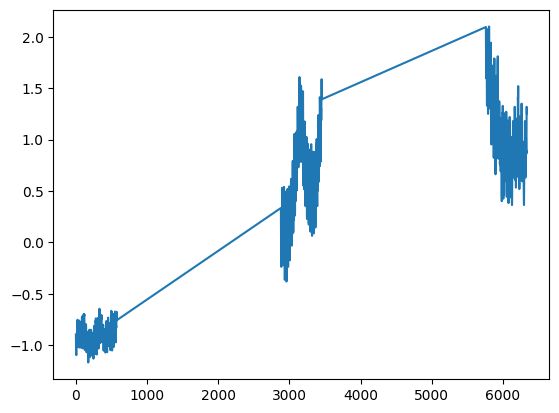

In [30]:
# plot consumption and temperature of bergen
y_test[X_test['city_number'] == 0].plot()

### Train model

In [31]:
import xgboost as xgb

In [32]:
# get dfs as numpy
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

print(X_train_np.shape)
print(y_train_np.shape)

# Create DMatrix for the current city
dtrain_city = xgb.DMatrix(X_train_np, label=y_train_np)

# Define XGBoost parameters for the current city's model
params = {
    'max_depth': 4,
    'eta': 0.5,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'  # or 'mae' or another suitable metric for your task
}

# Train the model for the current city
xg_model = xgb.train(params, dtrain_city, num_boost_round=100)

(29520, 556)
(29520,)


In [33]:
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()
print(X_test_np.shape, y_test_np.shape)

(8640, 556) (8640,)


### Get Predictions

In [34]:
# Create DMatrix for test set
dval_data = xgb.DMatrix(X_test_np)

# Predict using the trained model
xg_predictions = xg_model.predict(dval_data)

xg_truths = y_test_np
xg_truths.shape, xg_predictions.shape

((8640,), (8640,))

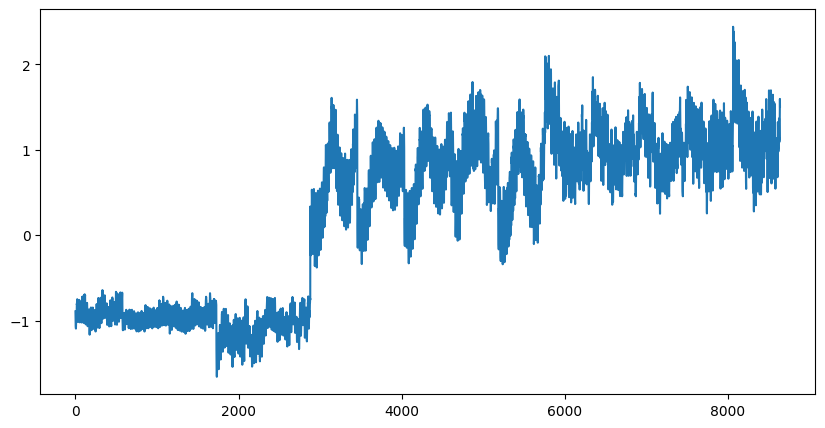

In [35]:
# check order of data (needed for reshaping below)
plt.figure(figsize=(10, 5))
plt.plot(xg_truths)

In [36]:
# NB: Quite tricky to get correct shapes!
# reshape the predictions
xg_predictions = np.transpose(xg_predictions.reshape(3, 5, -1), axes=(0, 2, 1))
# reshape the truths
xg_truths = np.transpose(xg_truths.reshape(3, 5, -1), axes=(0, 2, 1))

### Output Results

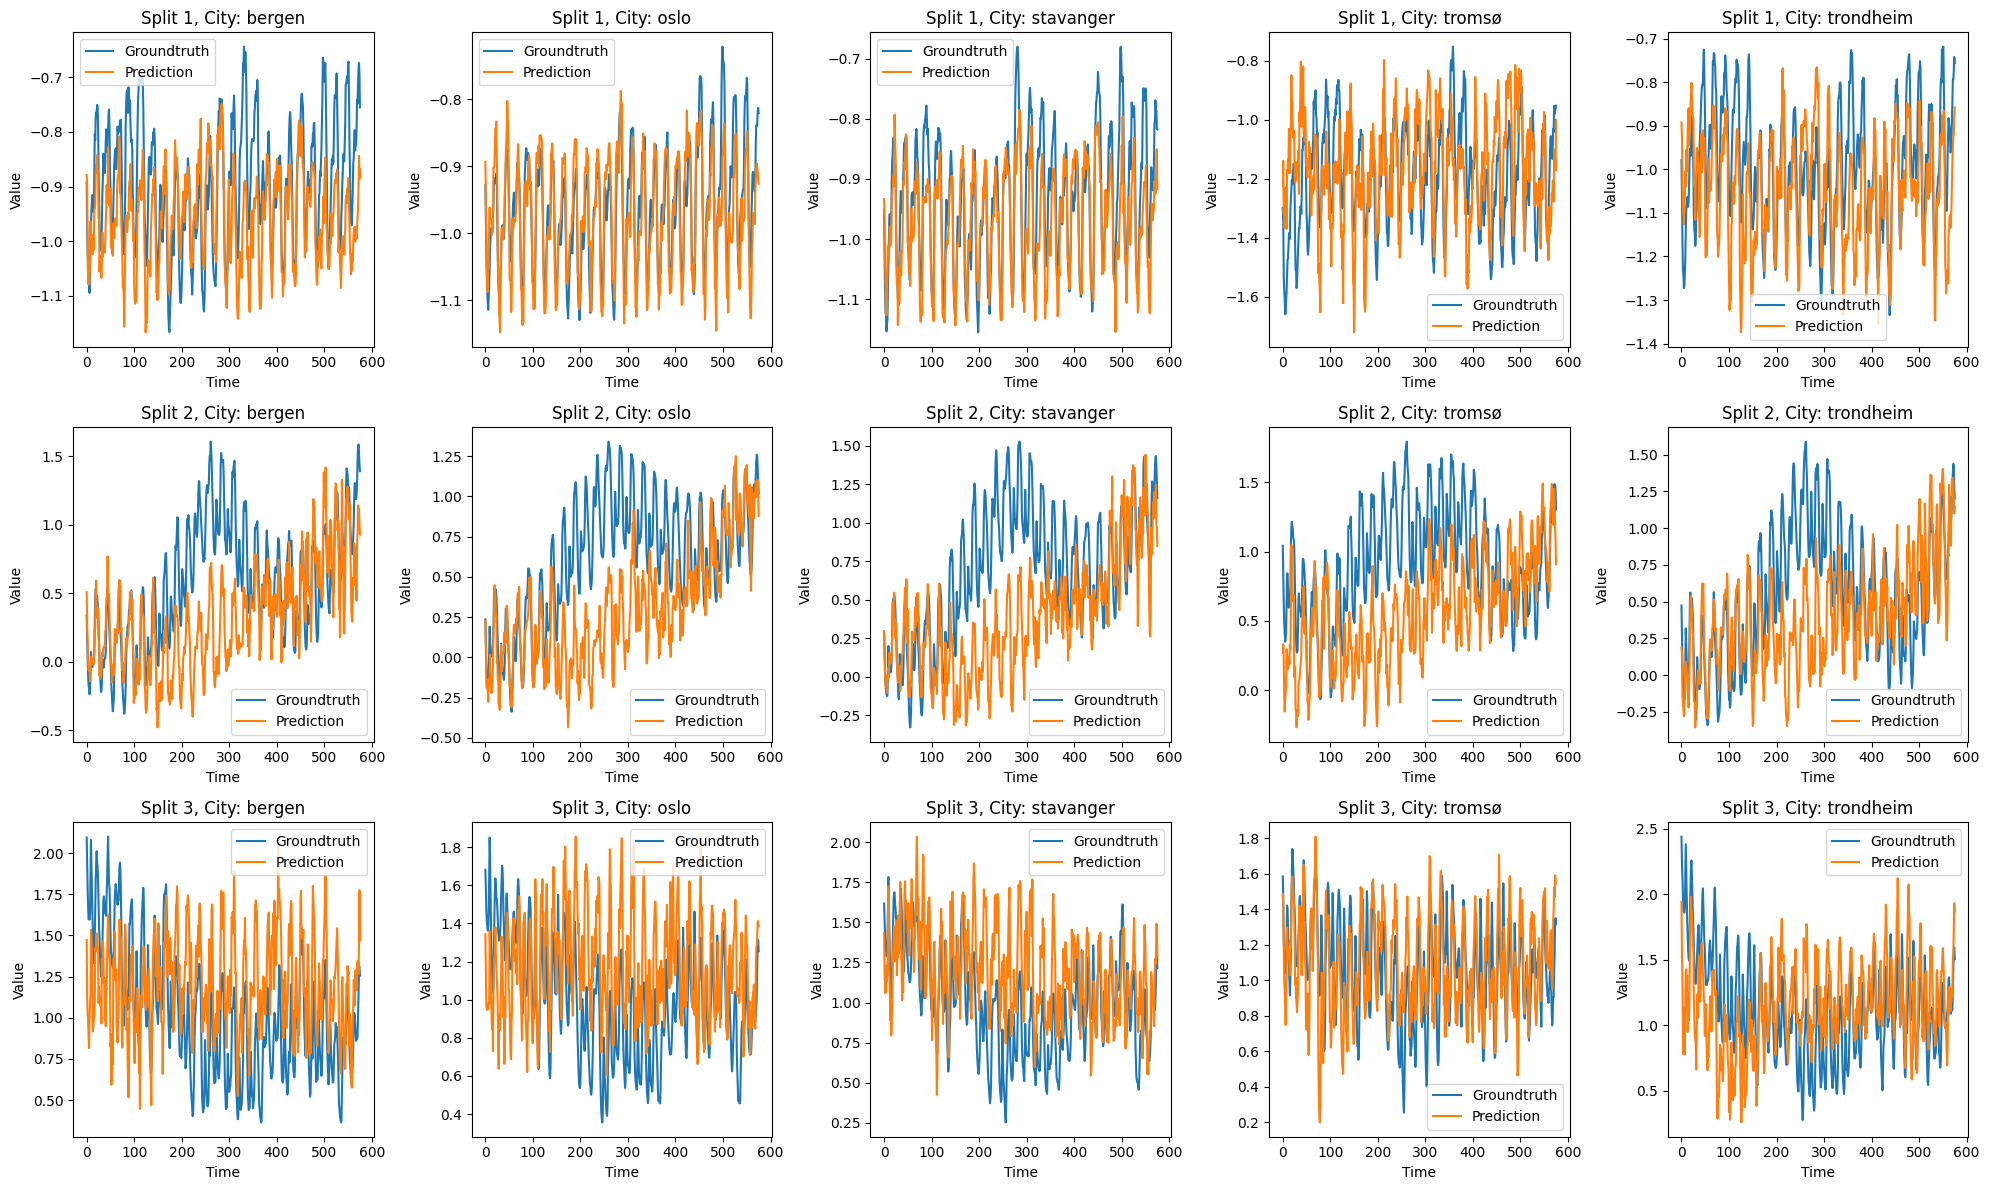

Metrics per City and Split:


Split  City       MAE       MSE      RMSE        MAPE
0       1     1  0.087202  0.011931  0.109228   10.504775
1       1     2  0.035211  0.002119  0.046035    3.785057
2       1     3  0.052023  0.004670  0.068338    5.960701
3       1     4  0.145438  0.031304  0.176929   12.415594
4       1     5  0.104893  0.015515  0.124557   11.082419
5       2     1  0.356944  0.218745  0.467702  154.238022
6       2     2  0.357598  0.208500  0.456618  150.244319
7       2     3  0.374221  0.236379  0.486188   81.396451
8       2     4  0.438856  0.268611  0.518277   58.584423
9       2     5  0.319759  0.172246  0.415026  162.442870
10      3     1  0.365550  0.176803  0.420480   43.128406
11      3     2  0.293539  0.122042  0.349346   35.009177
12      3     3  0.284436  0.117836  0.343273   35.685580
13      3     4  0.195480  0.056614  0.237937   20.998850
14      3     5  0.333542  0.158388  0.397980   34.671342


Average Metrics per City Across Splits:


City  Split       MAE       MSE      RMSE       MAPE
0     1    2.0  0.269899  0.135826  0.332470  69.290401
1     2    2.0  0.228783  0.110887  0.283999  63.012851
2     3    2.0  0.236893  0.119628  0.299266  41.014244
3     4    2.0  0.259924  0.118843  0.311048  30.666289
4     5    2.0  0.252731  0.115383  0.312521  69.398877


Overall Mean Metrics:
Mean MAE: 0.24964617047996882
Mean MSE: 0.12011358674881854
Mean RMSE: 0.3078608557325276
Mean MAPE: 54.67653236389988


In [37]:
# Visualize and get metrics
visualize_and_get_metrics(splits=3, prediction=xg_predictions, truth=xg_truths)

## XGBoost per city

### Train Models

In [38]:
xg_models = []

for idx, city in enumerate(cities):
    print(f'Training model for {city}')
    # Get the data for the current city
    X_train_city = X_train[X_train["city_number"] == idx]
    y_train_city = y_train[X_train["city_number"] == idx]

    # Create DMatrix for the current city
    dtrain_city = xgb.DMatrix(X_train_city.to_numpy(), label=y_train_city)

    # Define XGBoost parameters for the current city's model
    params = {
        'max_depth': 4,
        'eta': 0.5,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'  # or 'mae' or another suitable metric for your task
    }

    # Train the model for the current city
    xg_model = xgb.train(params, dtrain_city, num_boost_round=100)

    # Save the model
    xg_models.append(xg_model)

Training model for bergen
Training model for oslo
Training model for stavanger
Training model for tromsø
Training model for trondheim


### Get Predictions

In [39]:
xg_predictions = np.zeros((5, 1728))

for idx, city in enumerate(cities):
    # Get the data for the current city
    X_test_city = X_test[X_test["city_number"] == idx]

    # Create DMatrix for validation set of the current city
    dval_data = xgb.DMatrix(X_test_city.to_numpy())

    # Predict using the trained model
    xg_predictions[idx, :] = xg_models[idx].predict(dval_data)

### Output Results

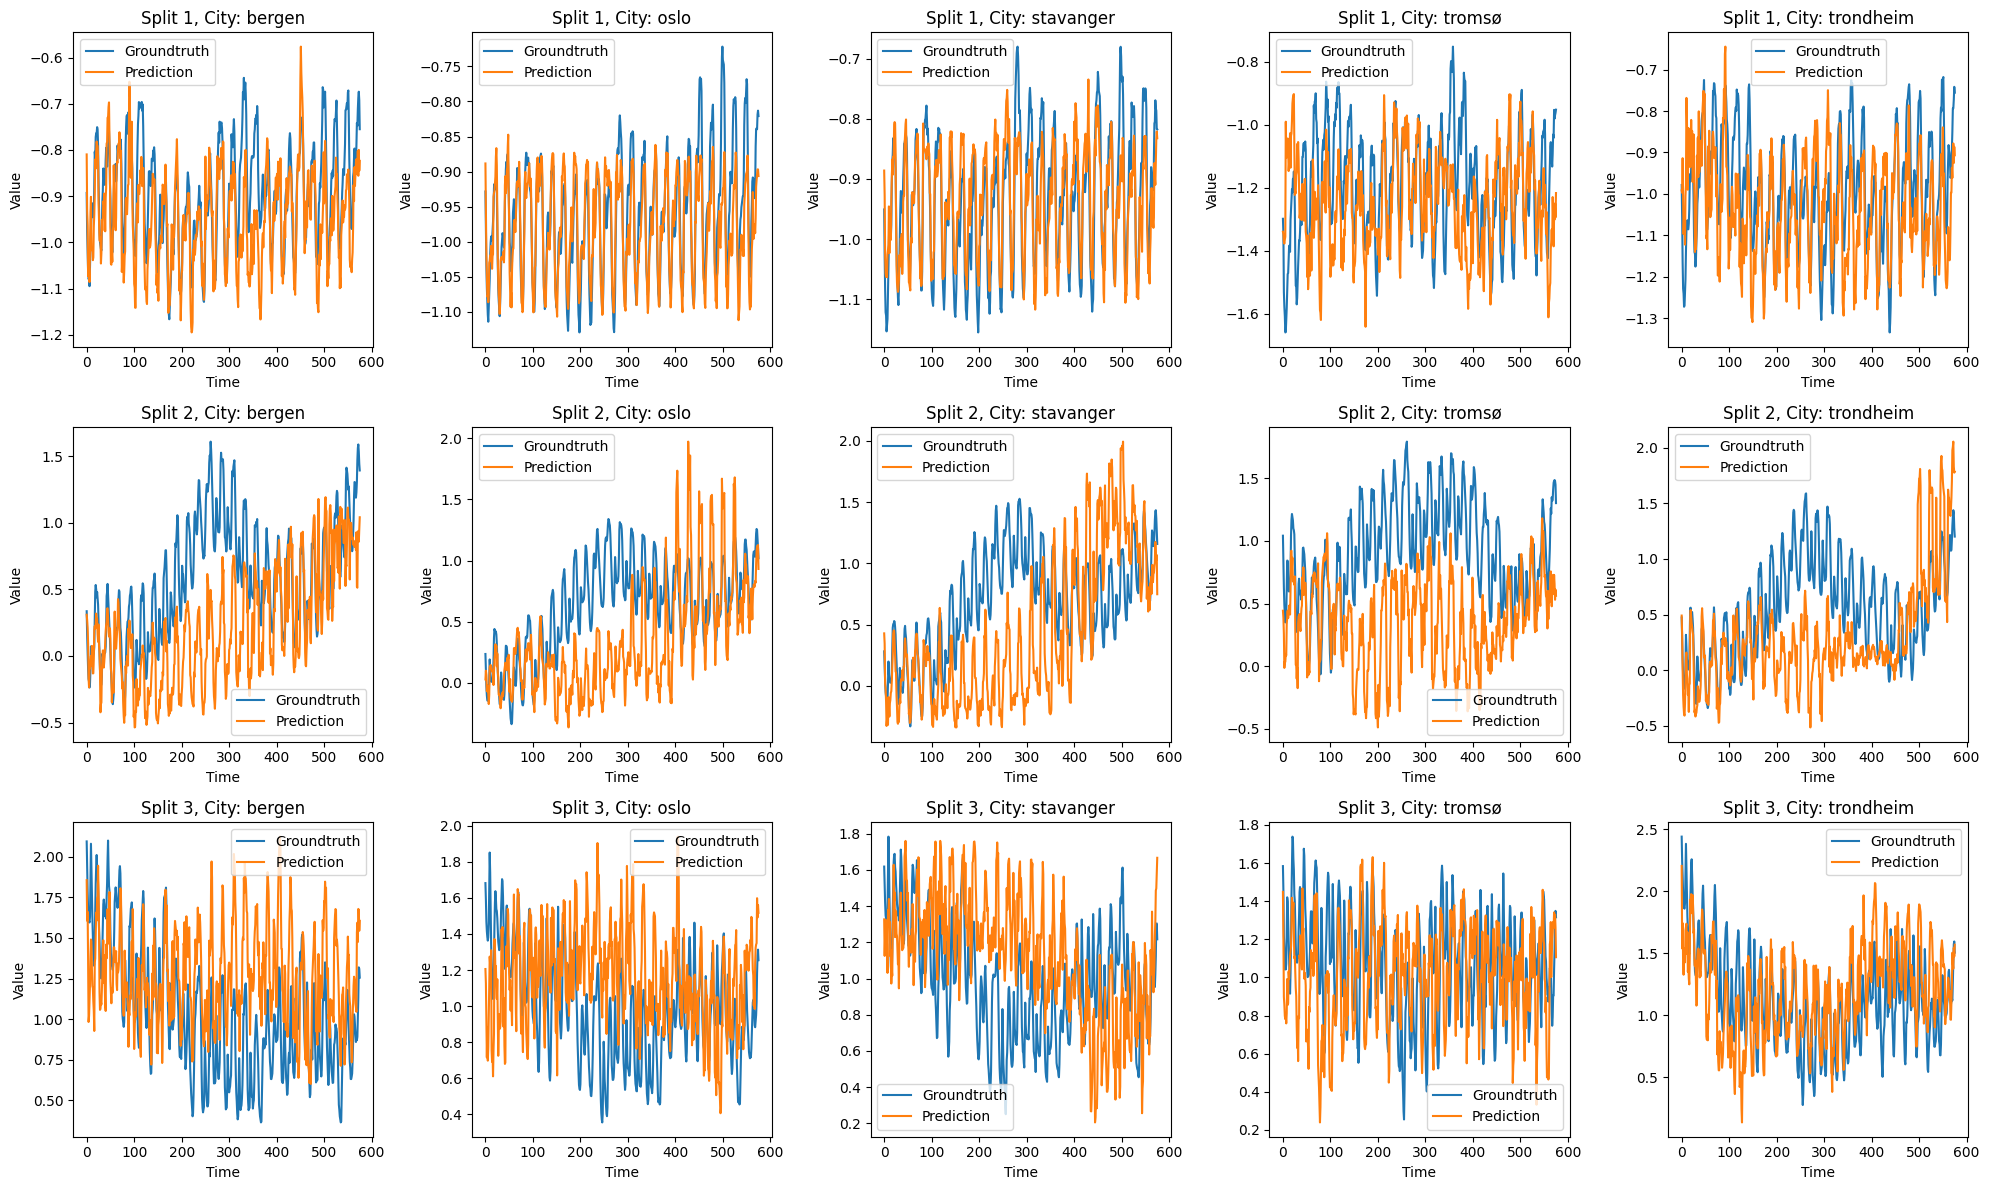

Metrics per City and Split:


Split  City       MAE       MSE      RMSE        MAPE
0       1     1  0.073796  0.009063  0.095199    8.852618
1       1     2  0.034190  0.002244  0.047367    3.759644
2       1     3  0.050422  0.003902  0.062468    5.628313
3       1     4  0.145016  0.034171  0.184854   12.785409
4       1     5  0.099830  0.014954  0.122287   10.508451
5       2     1  0.414763  0.280519  0.529640  205.831204
6       2     2  0.397778  0.246790  0.496779  130.105782
7       2     3  0.503022  0.375389  0.612690  118.045174
8       2     4  0.591817  0.502036  0.708545   74.857284
9       2     5  0.440729  0.309870  0.556659  191.348246
10      3     1  0.377102  0.194537  0.441063   46.902793
11      3     2  0.315176  0.140072  0.374262   38.486604
12      3     3  0.339090  0.160541  0.400676   42.686430
13      3     4  0.252498  0.093248  0.305365   26.777443
14      3     5  0.291675  0.128386  0.358310   30.561090


Average Metrics per City Across Splits:


City  Split       MAE       MSE      RMSE       MAPE
0     1    2.0  0.288554  0.161373  0.355301  87.195538
1     2    2.0  0.249048  0.129702  0.306136  57.450677
2     3    2.0  0.297511  0.179944  0.358611  55.453306
3     4    2.0  0.329777  0.209818  0.399588  38.140046
4     5    2.0  0.277412  0.151070  0.345752  77.472596


Overall Mean Metrics:
Mean MAE: 0.288460214931818
Mean MSE: 0.1663814351814535
Mean RMSE: 0.3530777430205356
Mean MAPE: 63.14243242134345


In [40]:
xg_predictions_reshaped = np.transpose(xg_predictions.reshape(5, 3, -1), axes=(1, 2, 0))
# Visualize and get metrics
visualize_and_get_metrics(splits=3, prediction=xg_predictions_reshaped, truth=xg_truths)

## XGBoost all cities Kfold

### Setup

In [41]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [42]:
X_train, y_train = get_X_y(train_val_tabulized_df)
X_test, y_test = get_X_y(test_tabulized_df)
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

### Do Random Search on TimeSeriesSplit

In [43]:
# get dfs as numpy
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

print(X_train_np.shape)
print(y_train_np.shape)

xg_model = xgb.XGBRegressor()

# Define XGBoost parameters for the current city's model
params = {
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'n_estimators': [50, 100, 200, 300],  # Number of boosting rounds
    'subsample': [0.5, 0.7, 0.9, 1],  # Subsample ratio of the training instances
    'colsample_bytree': [0.5, 0.7, 0.9, 1],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2, 3]  # L2 regularization term on weights
}

# create a time series split
tscv = TimeSeriesSplit(n_splits=3)
# for scoring check: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
random_search = RandomizedSearchCV(xg_model, param_distributions=params, n_iter=20, scoring='neg_mean_absolute_error', n_jobs=-1, cv=tscv, verbose=3, random_state=42)

# Fit the random search model
random_search.fit(X_train_np, y_train_np)

# get the best model
best_xg_model = random_search.best_estimator_


(29520, 556)
(29520,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
# Get the parameters of the best model
best_xg_model.get_params()

### Get Predictions

In [44]:
# Predict using the trained model
xg_predictions = best_xg_model.predict(X_test_np)

xg_truths = y_test_np
xg_truths.shape, xg_predictions.shape

((8640,), (8640,))

In [45]:
# reshape the predictions
xg_predictions = np.transpose(xg_predictions.reshape(3, 5, -1), axes=(0, 2, 1))
# reshape the truths
xg_truths = np.transpose(xg_truths.reshape(3, 5, -1), axes=(0, 2, 1))

In [46]:
xg_predictions.shape, xg_truths.shape

((3, 576, 5), (3, 576, 5))

### Output Results

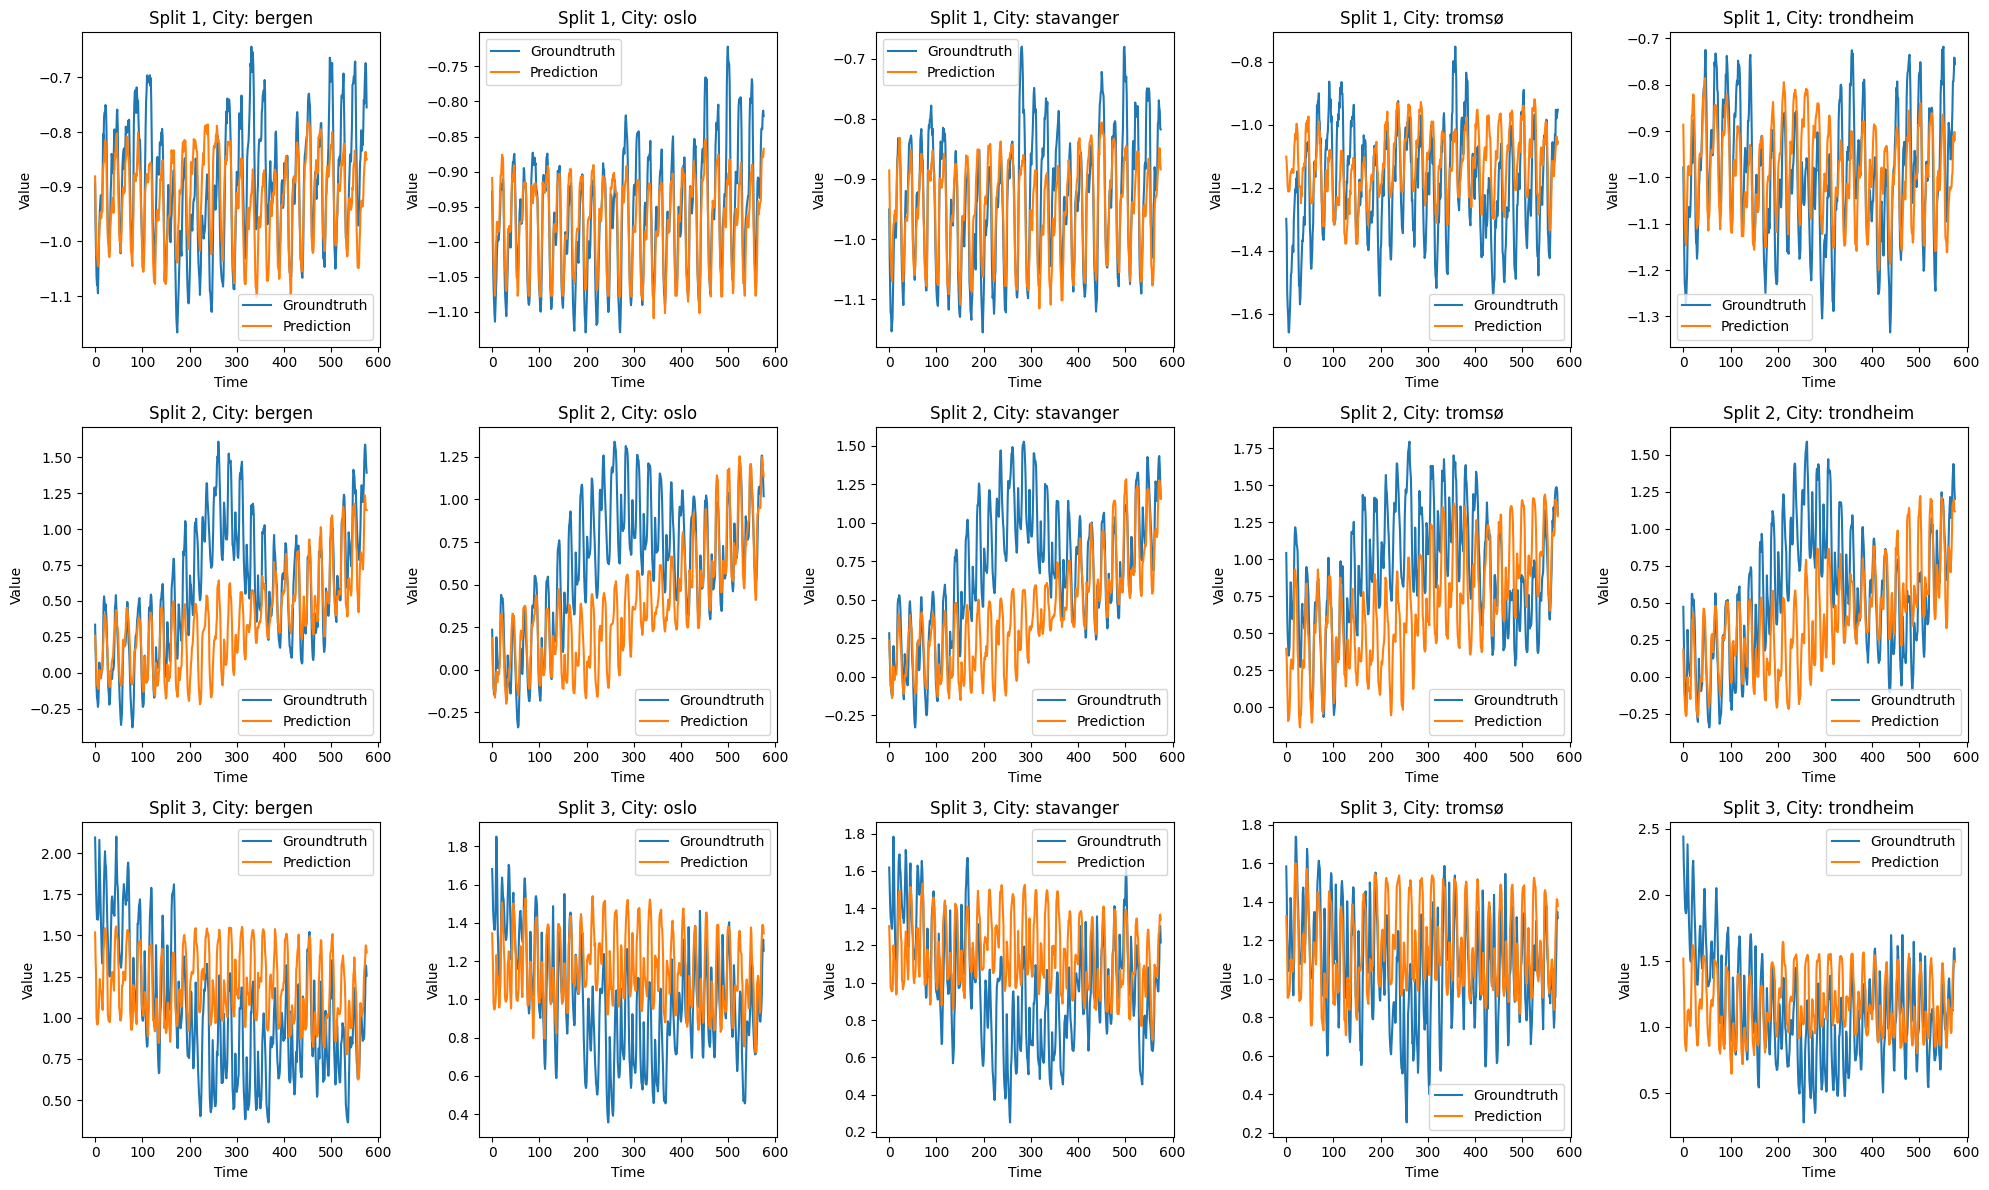

Metrics per City and Split:


Split  City       MAE       MSE      RMSE        MAPE
0       1     1  0.069349  0.007438  0.086242    8.233401
1       1     2  0.031399  0.001814  0.042596    3.435984
2       1     3  0.045898  0.003625  0.060205    5.240184
3       1     4  0.119155  0.021016  0.144969    9.869908
4       1     5  0.080746  0.008717  0.093367    8.362431
5       2     1  0.286325  0.163240  0.404030   71.240499
6       2     2  0.289689  0.148590  0.385473  106.886911
7       2     3  0.314485  0.180713  0.425104   66.620301
8       2     4  0.364303  0.183404  0.428257   47.446424
9       2     5  0.310326  0.159890  0.399863  156.984159
10      3     1  0.317341  0.134965  0.367376   39.562917
11      3     2  0.253722  0.095800  0.309515   32.242112
12      3     3  0.265246  0.105803  0.325274   35.072142
13      3     4  0.198270  0.060195  0.245346   22.913801
14      3     5  0.284287  0.120639  0.347331   30.167956


Average Metrics per City Across Splits:


City  Split       MAE       MSE      RMSE       MAPE
0     1    2.0  0.224338  0.101881  0.285882  39.678939
1     2    2.0  0.191604  0.082068  0.245861  47.521669
2     3    2.0  0.208543  0.096714  0.270194  35.644209
3     4    2.0  0.227243  0.088205  0.272857  26.743378
4     5    2.0  0.225119  0.096415  0.280187  65.171515


Overall Mean Metrics:
Mean MAE: 0.21536941799501416
Mean MSE: 0.09305652589713408
Mean RMSE: 0.2709964458254992
Mean MAPE: 42.951942066512515


In [47]:
# Visualize and get metrics
visualize_and_get_metrics(splits=3, prediction=xg_predictions, truth=xg_truths)

# Model 3: RNN-types: LSTM

## Setup Sequential

For RNNs (LSTM), and our modified Transformer model we need Sequence data.

We input sequences of 9 days at a time and inject the projected forecast.

In [48]:
df.head()

bergen_consumption  oslo_consumption  \
time                                                        
2022-04-07 21:00:00           -0.660391         -0.595758   
2022-04-07 22:00:00           -0.714890         -0.654558   
2022-04-07 23:00:00           -0.750819         -0.688184   
2022-04-08 00:00:00           -0.772093         -0.704646   
2022-04-08 01:00:00           -0.801390         -0.712036   

                     stavanger_consumption  tromsø_consumption  \
time                                                             
2022-04-07 21:00:00              -0.590128           -0.168468   
2022-04-07 22:00:00              -0.655851           -0.286978   
2022-04-07 23:00:00              -0.701877           -0.360968   
2022-04-08 00:00:00              -0.720685           -0.357688   
2022-04-08 01:00:00              -0.738556           -0.358079   

                     trondheim_consumption  bergen_temp  oslo_temp  \
time                                                                 
2022-04-07 21:00:00              -0.271248    -1.227807  -0.728916   
2022-04-07 22:00:00              -0.386136    -1.182052  -0.797328   
2022-04-07 23:00:00              -0.466829    -1.258311  -0.808730   
2022-04-08 00:00:00              -0.505958    -1.349822  -0.820132   
2022-04-08 01:00:00              -0.513762    -1.288814  -0.797328   

                     stavanger_temp  tromsø_temp  trondheim_temp  hour  \
time                                                                     
2022-04-07 21:00:00       -1.241145    -0.930639       -1.183463  21.0   
2022-04-07 22:00:00       -1.326767    -0.980848       -1.249112  22.0   
2022-04-07 23:00:00       -1.275394    -1.081266       -1.314761  23.0   
2022-04-08 00:00:00       -1.275394    -1.156579       -1.367279   0.0   
2022-04-08 01:00:00       -1.292518    -0.930639       -1.354150   1.0   

                     weekday  
time                          
2022-04-07 21:00:00      3.0  
2022-04-07 22:00:00      3.0  
2022-04-07 23:00:00      3.0  
2022-04-08 00:00:00      4.0  
2022-04-08 01:00:00      4.0

In [49]:
train_val_times.shape, test_times.shape

((3, 2304), (3, 576))

In [50]:
import datetime
def create_sequential_data_vectorized(df, times, sequence_length, is_train):
    start_offset = 0 if is_train else -24 * 14
    num_features = df.shape[1]
    split_length = times.shape[1]
    num_splits = times.shape[0]
    gap = 24 * 5

    # Compute the number of sequences
    num_sequences = (split_length - start_offset - gap - sequence_length) * num_splits
    print(f'Number of sequences: {num_sequences}')
    
    # Pre-allocate the arrays for efficiency
    sequences = np.zeros((num_sequences, sequence_length, num_features))
    next_parts = np.zeros((num_sequences, gap, num_features))
    print(f'Sequences shape: {sequences.shape}')
    print(f'Next parts shape: {next_parts.shape}')

    idx = 0
    for split in range(num_splits):
        time_step = times[split, 0]
        if not is_train:
            time_step = time_step - np.timedelta64(datetime.timedelta(hours=-start_offset), 's')
        time_series = time_step + np.arange(num_sequences / 3) * np.timedelta64(1, 'h')
        for time_ in time_series:
            # Get the time step
            time_step_plus_sequence = time_ + np.timedelta64(datetime.timedelta(hours=sequence_length), 's')
            time_step_plus_sequence_gap = time_step_plus_sequence + np.timedelta64(datetime.timedelta(hours=gap), 's')
            # Adjust the slicing to get the correct shape
            sequences[idx] = df.loc[time_:time_step_plus_sequence - 1].values
            next_parts[idx] = df.loc[time_step_plus_sequence:time_step_plus_sequence_gap - 1].values
            idx += 1

    return sequences, next_parts

def sequencize_data_vectorized(df, train_val_times, test_times):
    train_val_sequences, train_val_nexts = create_sequential_data_vectorized(df, train_val_times, 216, True)
    test_sequences, test_nexts = create_sequential_data_vectorized(df, test_times, 216, False)
    return train_val_sequences, train_val_nexts, test_sequences, test_nexts

# Example usage
# Assuming df, train_val_times, test_times are defined
train_val_sequencized, train_val_sequencized_nexts, test_sequencized, test_sequencized_nexts = sequencize_data_vectorized(df, train_val_times, test_times)

Number of sequences: 5904
Sequences shape: (5904, 216, 12)
Next parts shape: (5904, 120, 12)
Number of sequences: 1728
Sequences shape: (1728, 216, 12)
Next parts shape: (1728, 120, 12)


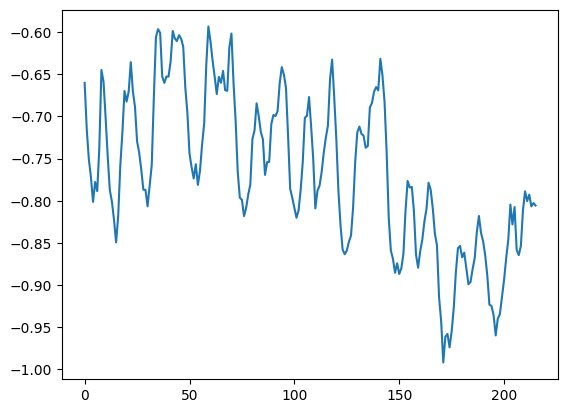

In [51]:
# plot bergen consumption
plt.plot(train_val_sequencized[0, :, 0])

Days seems to line up

Function to count parameters

In [52]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

## LSTM-1 Per city

### Setup Model

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim

class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size=12, hidden_size=64, num_layers=1, output_size=1):
        super(TimeSeriesLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, verbose=False): #hidden=None, 
        # Input x shape: (batch_size, sequence_length, input_size)
        
        # If no hidden state is provided, initialize to zero. 
        # This seemed to not make a difference in the results.
        # if hidden is None:
        #     batch_size = x.size(0)
        #     hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device),
        #             torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device))
        
        # LSTM
        out, _ = self.lstm(x)  # out shape: (batch_size, sequence_length, hidden_size)

        if verbose:
            print('1:', out.shape)
        
        # Take the relevant steps from the LSTM output
        out = out[:, :, :]

        if verbose:
            print('2:', out.shape)
        
        # Linear layer to get the output
        out = self.linear(out)  # out shape: (batch_size, 4, output_size)

        out = out[:, :, -1:]
        # out = out.view(-1, 1, 216)

        if verbose:
            print('3:',out.shape)
        
        return out
    
model = TimeSeriesLSTM()
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 20033
Trainable parameters: 20033


In [54]:
model = TimeSeriesLSTM().to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = torch.randn(100, 216, 12, device='cuda')
out = model(input, verbose=True)

1: torch.Size([100, 216, 64])
2: torch.Size([100, 216, 64])
3: torch.Size([100, 216, 1])


### Setup dataset

In [55]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get data as tensors
train_X = torch.tensor(train_val_sequencized, dtype=torch.float32).to(device)
train_y = torch.tensor(train_val_sequencized_nexts, dtype=torch.float32).to(device)
test_X = torch.tensor(test_sequencized, dtype=torch.float32).to(device)
test_y = torch.tensor(test_sequencized_nexts, dtype=torch.float32).to(device)

### Train model

In [56]:
# Try to predict each city separately
criterion = nn.MSELoss()
lr = 0.0005
batch_size = 128
epochs = 20

# Training loop
def train_model_per_city(model, train_loader, criterion, optimizer, epochs, city_num):
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)[:, :120, 0]

            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the models
models = []
print(train_X.shape)
print(train_y[:, :, 0].shape)
for i in range(5):
    # Instantiate dataset
    train_dataset = TimeSeriesDataset(train_X, train_y[:, :, i])
    # Instantiate data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    print(f"Training model for city {i+1}")
    model = TimeSeriesLSTM().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_model_per_city(model, train_loader, criterion, optimizer, epochs=epochs, city_num=i)
    models.append(model)

torch.Size([5904, 216, 12])
torch.Size([5904, 120])
Training model for city 1


C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\2855495362.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\2855495362.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


Epoch [2/20], Loss: 0.0720
Epoch [4/20], Loss: 0.0478
Epoch [6/20], Loss: 0.0353
Epoch [8/20], Loss: 0.0227
Epoch [10/20], Loss: 0.0239
Epoch [12/20], Loss: 0.0260
Epoch [14/20], Loss: 0.0134
Epoch [16/20], Loss: 0.0274
Epoch [18/20], Loss: 0.0210
Epoch [20/20], Loss: 0.0176
Training model for city 2
Epoch [2/20], Loss: 0.1068
Epoch [4/20], Loss: 0.0616
Epoch [6/20], Loss: 0.0636
Epoch [8/20], Loss: 0.0341
Epoch [10/20], Loss: 0.0483
Epoch [12/20], Loss: 0.0414
Epoch [14/20], Loss: 0.0343
Epoch [16/20], Loss: 0.0333
Epoch [18/20], Loss: 0.0284
Epoch [20/20], Loss: 0.0165
Training model for city 3
Epoch [2/20], Loss: 0.0823
Epoch [4/20], Loss: 0.0588
Epoch [6/20], Loss: 0.0396
Epoch [8/20], Loss: 0.0617
Epoch [10/20], Loss: 0.0494
Epoch [12/20], Loss: 0.0222
Epoch [14/20], Loss: 0.0219
Epoch [16/20], Loss: 0.0327
Epoch [18/20], Loss: 0.0159
Epoch [20/20], Loss: 0.0177
Training model for city 4
Epoch [2/20], Loss: 0.0980
Epoch [4/20], Loss: 0.0662
Epoch [6/20], Loss: 0.0872
Epoch [8/20],

### Get predictions on test-set

In [58]:
# Assuming test_X is your test data and has the same format as your training data
def get_predictions_per_city(models, test_X):
    predictions = []
    with torch.no_grad():  # No need to track gradients during prediction
        for model_idx, model in enumerate(models):
            model.eval()  # Set the model to evaluation mode
            city_predictions = []
            output = model(test_X)[:, -1:, 0]  # Adjust this line if needed
            city_predictions.append(output.cpu().numpy())
            city_predictions = np.concatenate(city_predictions, axis=0)
            predictions.append(city_predictions)
    return predictions

# Get predictions
all_city_predictions = get_predictions_per_city(models, test_X)

# Convert to NumPy array
all_city_predictions = np.array(all_city_predictions)
all_city_predictions.shape

(5, 1728, 1)

In [59]:
lstm1_preds = all_city_predictions[:, :, 0].reshape(5, 3, -1).transpose(1, 2, 0)
lstm1_preds.shape, xg_truths.shape

((3, 576, 5), (3, 576, 5))

### Output results

In [2]:
visualize_and_get_metrics(splits=3, prediction=lstm1_preds, truth=xg_truths)

NameError: name 'visualize_and_get_metrics' is not defined

## LSTM-1 1 model 

### Reuse same LSTM model, but different output size

In [85]:
  
model = TimeSeriesLSTM(output_size=5)
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 20293
Trainable parameters: 20293


In [86]:
model = TimeSeriesLSTM(output_size=5).to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = torch.randn(100, 216, 12, device='cuda')
out = model(input, verbose=True)

1: torch.Size([100, 216, 64])
2: torch.Size([100, 216, 64])
3: torch.Size([100, 216, 5])


In [118]:
train_X.shape, train_y.shape

(torch.Size([5904, 216, 12]), torch.Size([5904, 120, 12]))

### Train model

In [147]:
# Try to predict each city separately
criterion = nn.MSELoss()
lr = 0.0003
batch_size = 256
epochs = 50
# lr = 0.0005
# batch_size = 128
# epochs = 20

# NB This can either be trained to predict the whole next sequence, or just for the hour in question.
# Did not see much difference in performance.

# Training loop
def train_model_lstm1(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)[:, 119, :5]
            # print(outputs.shape)
            # print(batch_y.shape)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the models
lstm_model1 = TimeSeriesLSTM(hidden_size=128, output_size=5).to(device)
# print(train_y.shape)
train_dataset = TimeSeriesDataset(train_X, train_y[:, 119, :5])
# Instantiate data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lstm_optimizer1 = optim.Adam(lstm_model1.parameters(), lr=lr)
train_model_lstm1(lstm_model1, train_loader, criterion, lstm_optimizer1, epochs=epochs)

C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\2855495362.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\2855495362.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


Epoch [5/50], Loss: 0.1034
Epoch [10/50], Loss: 0.0482
Epoch [15/50], Loss: 0.0405
Epoch [20/50], Loss: 0.0189
Epoch [25/50], Loss: 0.0247
Epoch [30/50], Loss: 0.0370
Epoch [35/50], Loss: 0.0329
Epoch [40/50], Loss: 0.0410
Epoch [45/50], Loss: 0.0321
Epoch [50/50], Loss: 0.0163


### Get predictions

In [148]:
# Assuming test_X is your test data and has the same format as your training data
def get_predictions_lstm1(model, test_X):
    with torch.no_grad():  # No need to track gradients during prediction
        model.eval()  # Set the model to evaluation mode
        city_predictions = []
        print(test_X.shape)
        output = model(test_X)[:, 120, :]  # Adjust this line if needed
        print(output.shape)
        city_predictions.append(output.cpu().numpy())
        city_predictions = np.concatenate(city_predictions, axis=0)
    return city_predictions

# Get predictions
all_city_predictions = get_predictions_lstm1(lstm_model1, test_X)

# Convert to NumPy array
all_city_predictions = np.array(all_city_predictions)
all_city_predictions.shape

torch.Size([1728, 216, 12])
torch.Size([1728, 5])


(1728, 5)

In [149]:
lstmall_preds = all_city_predictions.reshape(3, -1, 5)
lstmall_preds.shape

(3, 576, 5)

### Output results

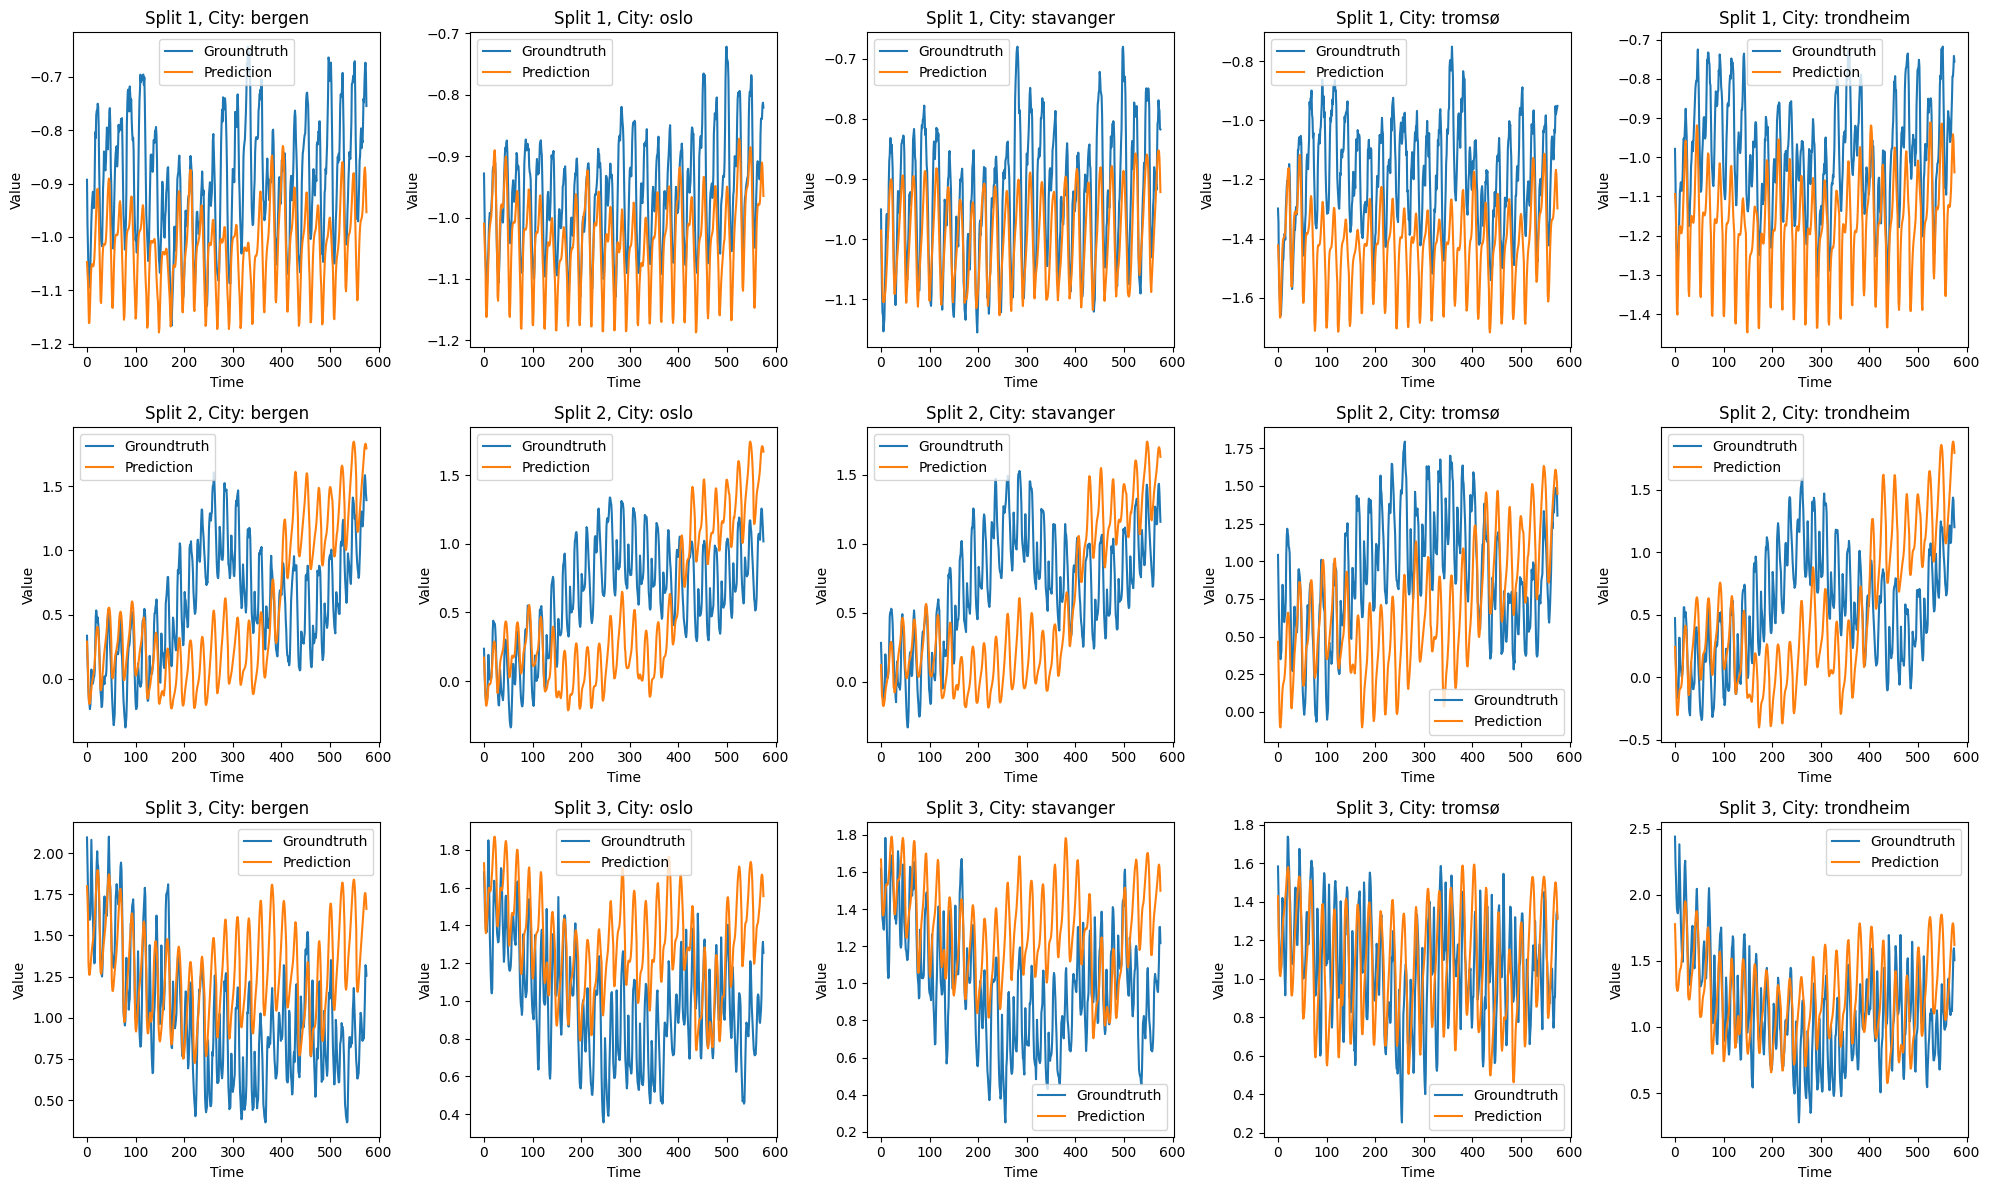

Metrics per City and Split:


Split  City       MAE       MSE      RMSE        MAPE
0       1     1  0.130240  0.022597  0.150323   15.655858
1       1     2  0.076999  0.007991  0.089394    8.299246
2       1     3  0.067552  0.006982  0.083555    7.795292
3       1     4  0.241749  0.073258  0.270663   21.790332
4       1     5  0.178511  0.039137  0.197831   18.959752
5       2     1  0.482024  0.326243  0.571177  311.883343
6       2     2  0.471513  0.287473  0.536165  207.197526
7       2     3  0.492785  0.338802  0.582067  106.021319
8       2     4  0.444899  0.271168  0.520738   75.129234
9       2     5  0.531180  0.371787  0.609743  223.092544
10      3     1  0.351955  0.185222  0.430374   46.091600
11      3     2  0.354038  0.178219  0.422159   44.738560
12      3     3  0.348058  0.178643  0.422662   46.067246
13      3     4  0.247545  0.097087  0.311588   27.743895
14      3     5  0.287539  0.135731  0.368417   32.143286


Average Metrics per City Across Splits:


City  Split       MAE       MSE      RMSE        MAPE
0     1    2.0  0.321406  0.178021  0.383958  124.543600
1     2    2.0  0.300850  0.157894  0.349240   86.745111
2     3    2.0  0.302798  0.174809  0.362761   53.294619
3     4    2.0  0.311398  0.147171  0.367663   41.554487
4     5    2.0  0.332410  0.182218  0.391997   91.398527


Overall Mean Metrics:
Mean MAE: 0.3137723255149742
Mean MSE: 0.16802265432952906
Mean RMSE: 0.37112381743315503
Mean MAPE: 79.50726888983709


In [151]:
visualize_and_get_metrics(splits=3, prediction=lstmall_preds, truth=xg_truths)

## Dual-Input LSTM

### Setup Model

In [166]:
class DualInputLSTM(nn.Module):
    def __init__(self, consumption_size, temperature_size, hidden_layer_size, output_size):
        super(DualInputLSTM, self).__init__()
        
        # LSTM for consumption data
        self.lstm_consumption = nn.LSTM(consumption_size, hidden_layer_size, batch_first=True)
        
        # LSTM for temperature data
        self.lstm_temperature_plus = nn.LSTM(temperature_size, hidden_layer_size, batch_first=True)
        
        # Linear layer to combine the outputs of the two LSTMs
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)
    
    def forward(self, consumption_seq, temperature_seq, verbose=False):
        # Process each sequence through its respective LSTM
        lstm_out_consumption, _ = self.lstm_consumption(consumption_seq)
        lstm_out_temperature, _ = self.lstm_temperature_plus(temperature_seq)

        if verbose:
            print('1:', lstm_out_consumption.shape)
            print('2:', lstm_out_temperature.shape)
        
        # Concatenate the final outputs of each LSTM
        combined = torch.cat((lstm_out_consumption[:, :, :], lstm_out_temperature[:, :216, :]), 2)

        if verbose:
            print('3:', combined.shape)
        
        # Make predictions based on the combined output
        predictions = self.linear(combined)

        if verbose:
            print('4:', predictions.shape)
        return predictions

model = DualInputLSTM(5, 7, 64, 5)
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 37509
Trainable parameters: 37509


In [167]:
model = DualInputLSTM(5, 7, 64, 5).to('cuda')
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input_con = torch.randn(100, 216, 5, device='cuda')
input_rest = torch.randn(100, 336, 7, device='cuda')
out = model(input_con, input_rest, verbose=True)

1: torch.Size([100, 216, 64])
2: torch.Size([100, 336, 64])
3: torch.Size([100, 216, 128])
4: torch.Size([100, 216, 5])


### Train Model

In [189]:
# Try to predict each city separately
criterion = nn.MSELoss()
lr = 0.0003
batch_size = 256
epochs = 50

# NB This can either be trained to predict the whole next sequence, or just for the hour in question.
# Did not see much difference in performance.

# Training loop
def train_model_lstm_dual(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            # print('x',batch_X.shape)
            # print('y',batch_y.shape)
            consumption_inputs = batch_X[:, :, :5]
            # print(consumption_inputs.shape)
            rest_inputs = torch.cat((batch_X[:, :, 5:], batch_y[:, :, 5:]), 1)
            # print(rest_inputs.shape)
            outputs = model(consumption_inputs,rest_inputs)[:, :120, :]
            # print('o',outputs.shape)
            # print('by',batch_y.shape)
            loss = criterion(outputs, batch_y[:, :120, :5])
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the models
lstm_model2 = DualInputLSTM(5, 7, 64, 5).to(device)
# print(train_y.shape)
train_dataset = TimeSeriesDataset(train_X, train_y)
# Instantiate data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lstm_optimizer2 = optim.Adam(lstm_model2.parameters(), lr=lr)
train_model_lstm_dual(lstm_model2, train_loader, criterion, lstm_optimizer2, epochs=epochs)

C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\2729082751.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\2729082751.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


Epoch [5/50], Loss: 0.1270
Epoch [10/50], Loss: 0.0725
Epoch [15/50], Loss: 0.0654
Epoch [20/50], Loss: 0.0446
Epoch [25/50], Loss: 0.0452
Epoch [30/50], Loss: 0.0486
Epoch [35/50], Loss: 0.0271
Epoch [40/50], Loss: 0.0348
Epoch [45/50], Loss: 0.0440
Epoch [50/50], Loss: 0.0296


### Get Predictions

In [192]:
# Assuming test_X is your test data and has the same format as your training data
def get_predictions_lstm2(model, test_X, test_y):
    with torch.no_grad():  # No need to track gradients during prediction
        model.eval()  # Set the model to evaluation mode
        city_predictions = []
        print(test_X.shape)
        consumption_inputs = test_X[:, :, :5]
        # print(consumption_inputs.shape)
        rest_inputs = torch.cat((test_X[:, :, 5:], test_y[:, :, 5:]), 1)
        output = model(consumption_inputs, rest_inputs)[:, 120, :] 
        print(output.shape)
        city_predictions.append(output.cpu().numpy())
        city_predictions = np.concatenate(city_predictions, axis=0)
    return city_predictions

# Get predictions
all_city_predictions = get_predictions_lstm2(lstm_model2, test_X, test_y)

# Convert to NumPy array
all_city_predictions = np.array(all_city_predictions)
print(all_city_predictions.shape)
lstmall_preds = all_city_predictions.reshape(3, -1, 5)
lstmall_preds.shape

torch.Size([1728, 216, 12])
torch.Size([1728, 5])


(1728, 5)

### Output Results

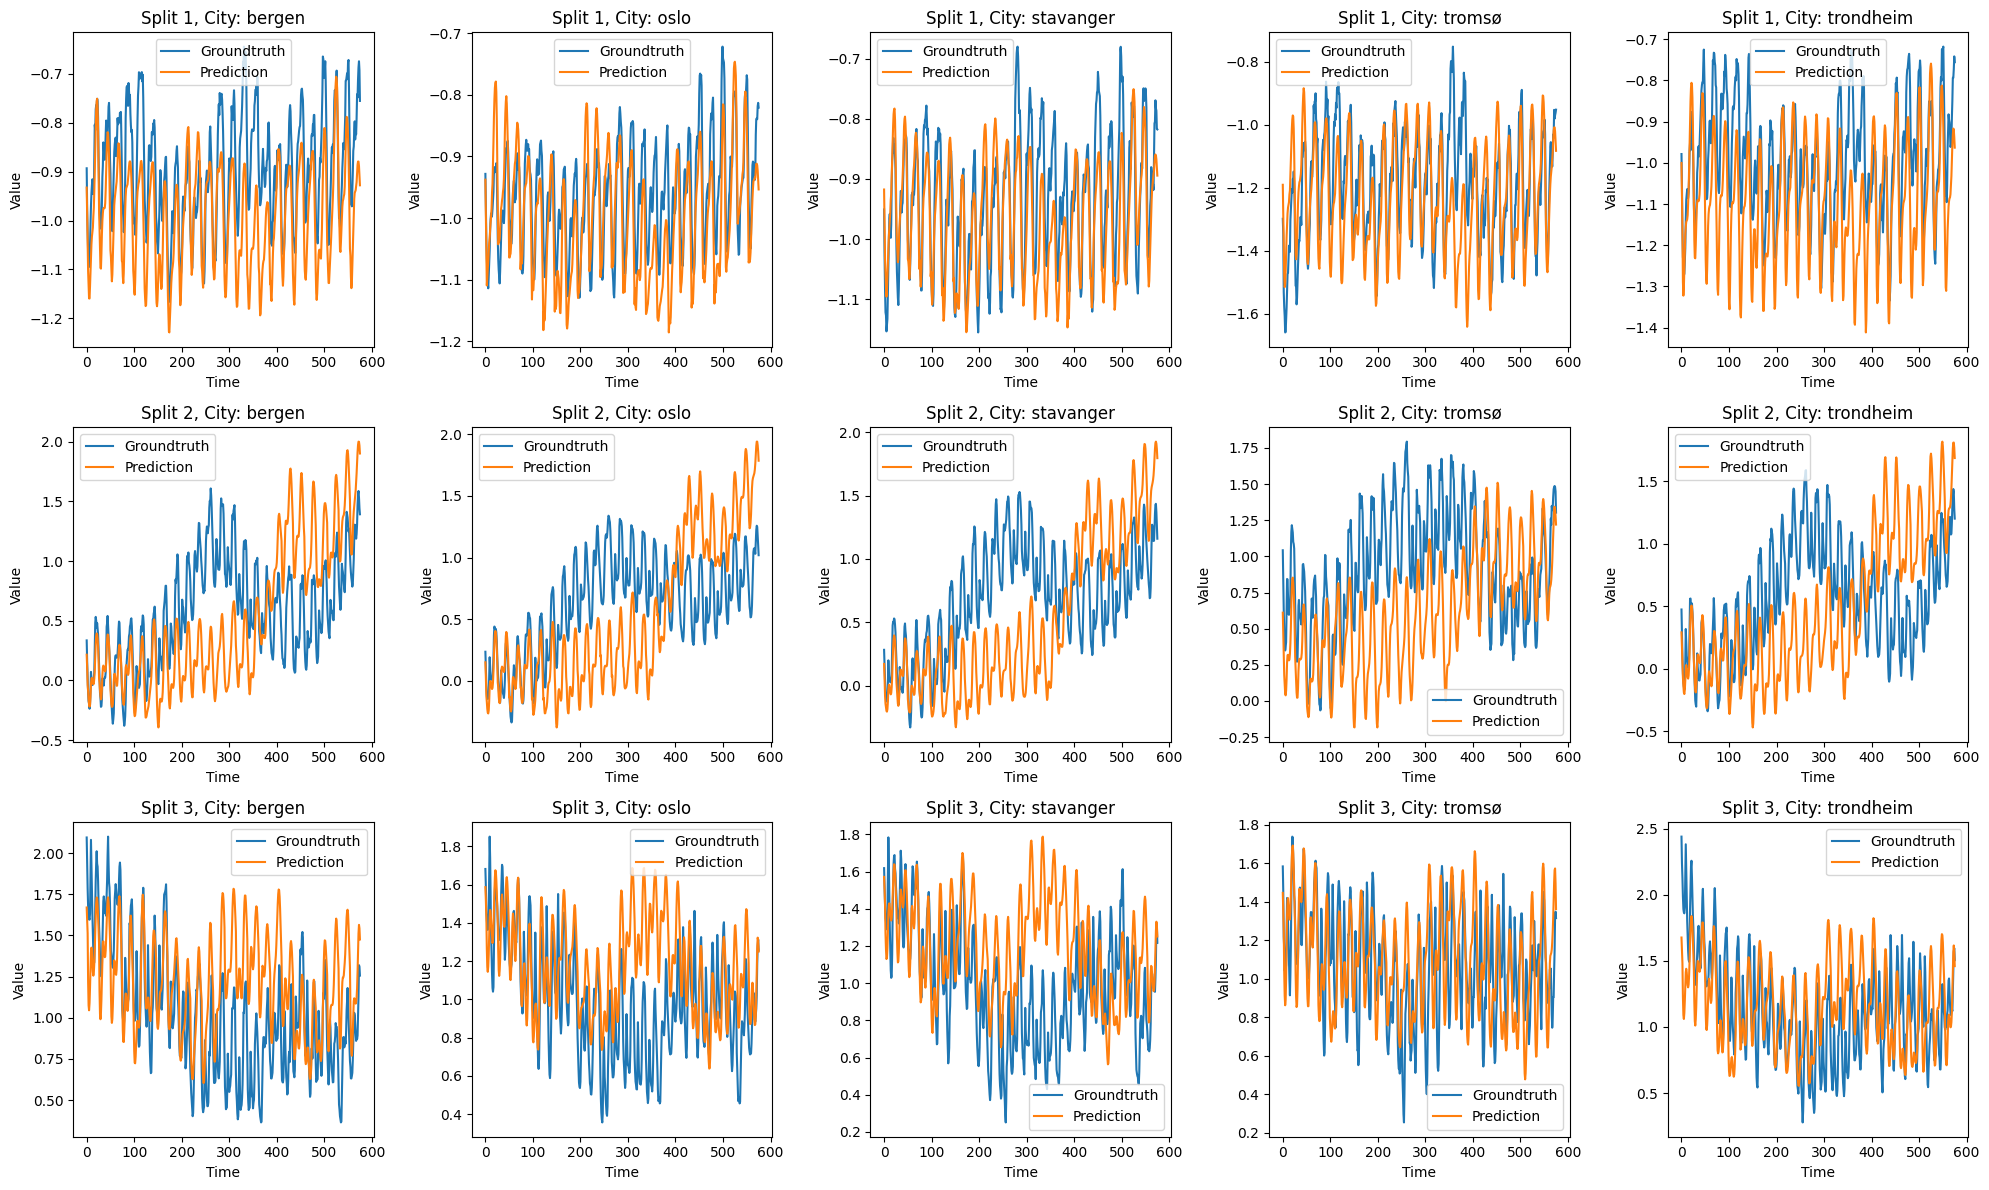

Metrics per City and Split:


Split  City       MAE       MSE      RMSE        MAPE
0       1     1  0.102710  0.014825  0.121758   12.091082
1       1     2  0.061913  0.005522  0.074312    6.548632
2       1     3  0.057453  0.005247  0.072433    6.474551
3       1     4  0.109222  0.020648  0.143695    9.716729
4       1     5  0.119512  0.020911  0.144607   12.657468
5       2     1  0.460998  0.303238  0.550671  257.869409
6       2     2  0.468858  0.289872  0.538397  167.346832
7       2     3  0.490208  0.325609  0.570622  104.215400
8       2     4  0.430572  0.259145  0.509062   56.375862
9       2     5  0.486363  0.320632  0.566244  216.588004
10      3     1  0.314564  0.149712  0.386926   40.395485
11      3     2  0.259747  0.110937  0.333072   33.508037
12      3     3  0.299172  0.143822  0.379238   39.406414
13      3     4  0.205348  0.069617  0.263849   23.177228
14      3     5  0.269674  0.113927  0.337531   28.375415


Average Metrics per City Across Splits:


City  Split       MAE       MSE      RMSE        MAPE
0     1    2.0  0.292757  0.155925  0.353118  103.451992
1     2    2.0  0.263506  0.135444  0.315260   69.134500
2     3    2.0  0.282278  0.158226  0.340764   50.032122
3     4    2.0  0.248381  0.116470  0.305536   29.756606
4     5    2.0  0.291850  0.151823  0.349461   85.873629


Overall Mean Metrics:
Mean MAE: 0.27575423880691596
Mean MSE: 0.1435775397116235
Mean RMSE: 0.3328278593596237
Mean MAPE: 67.64976983021934


In [194]:
visualize_and_get_metrics(splits=3, prediction=lstmall_preds, truth=xg_truths)

## Combine XG + LSTM Dual-input

In [195]:
combined_preds = (lstmall_preds + xg_predictions) / 2

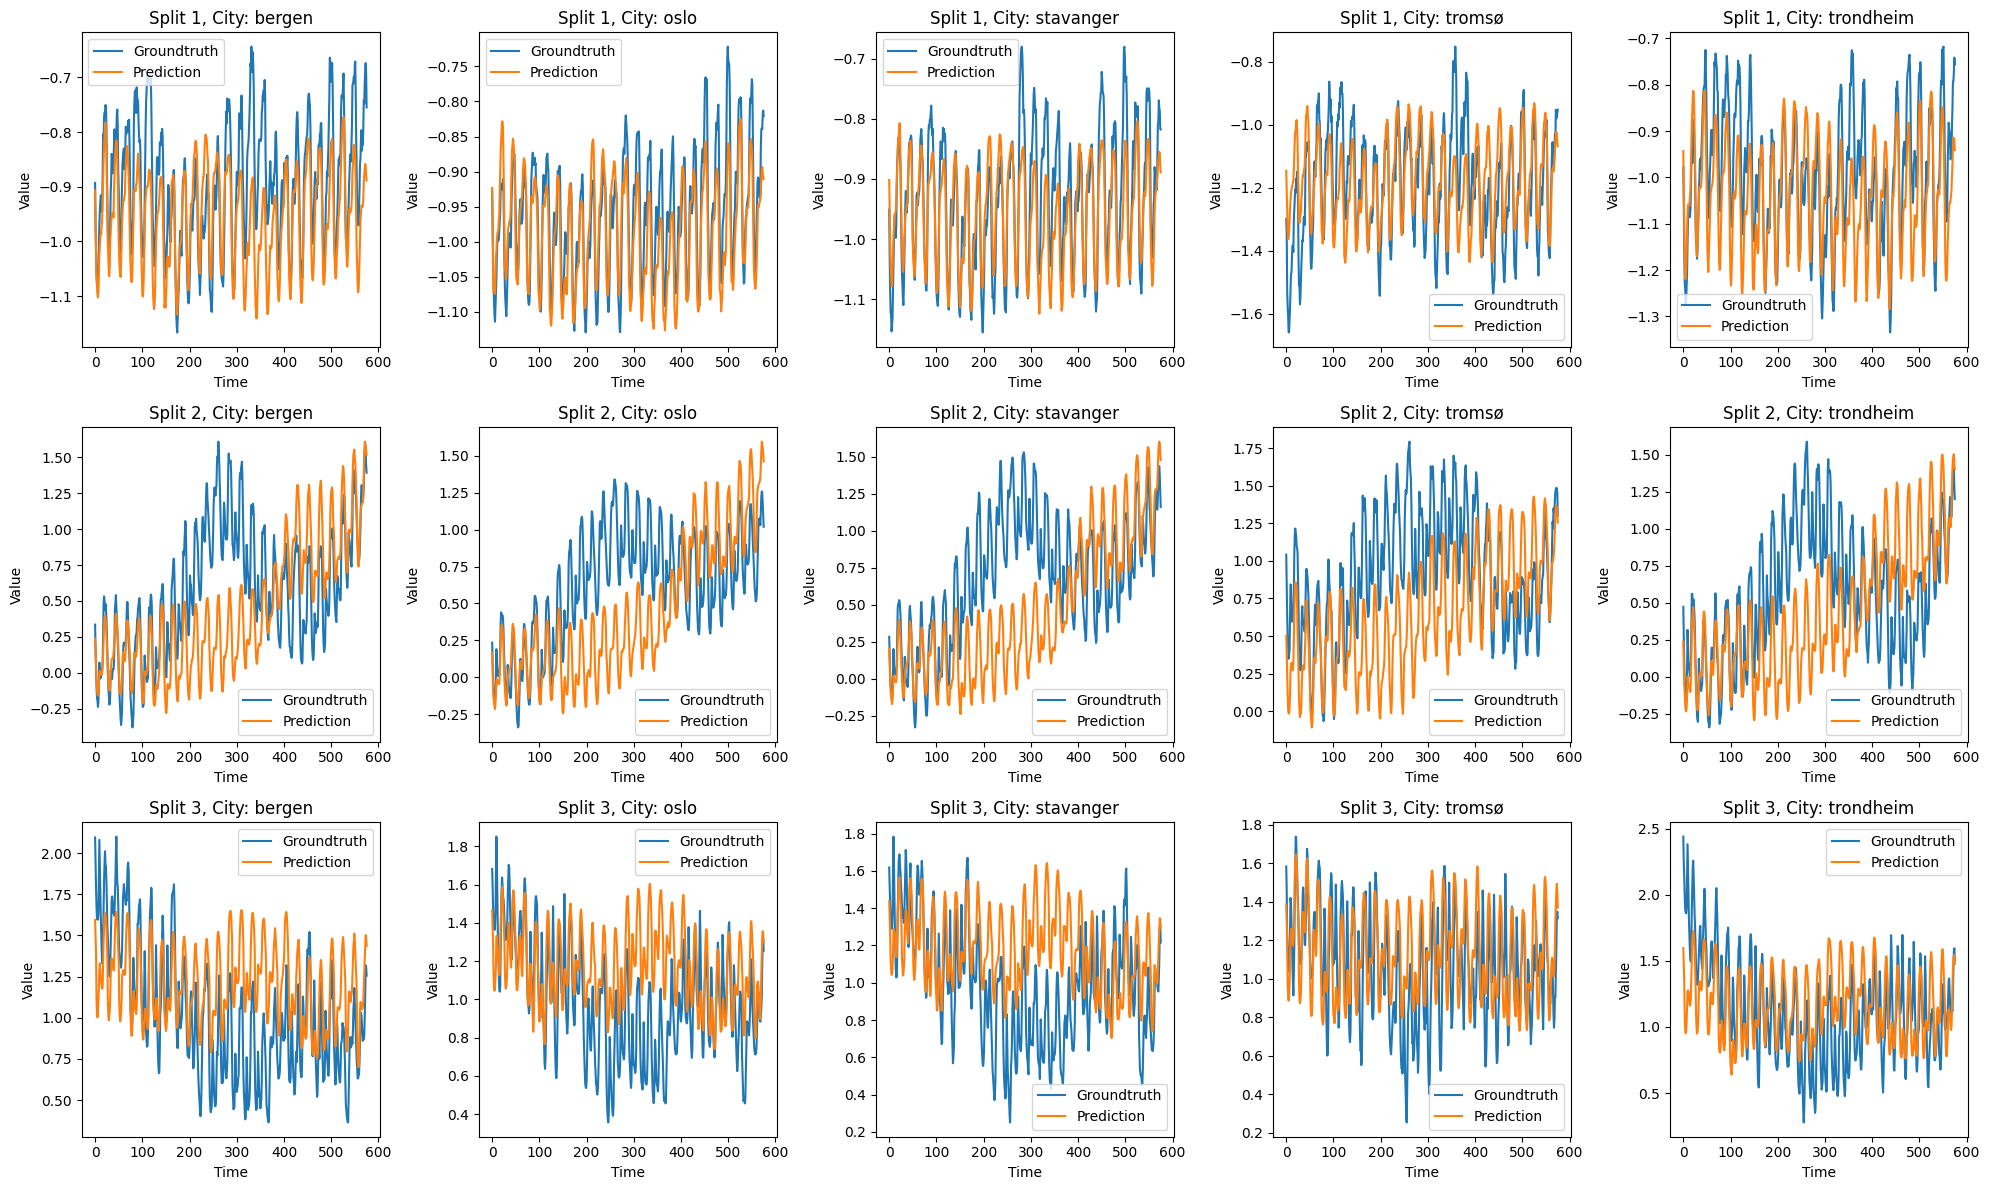

Metrics per City and Split:


Split  City       MAE       MSE      RMSE        MAPE
0       1     1  0.078111  0.009194  0.095885    9.359472
1       1     2  0.041576  0.002519  0.050189    4.473269
2       1     3  0.047359  0.003789  0.061556    5.402515
3       1     4  0.097493  0.015024  0.122572    8.464110
4       1     5  0.085143  0.010572  0.102821    9.124543
5       2     1  0.339579  0.195623  0.442293  156.462724
6       2     2  0.357862  0.185512  0.430711  117.573988
7       2     3  0.373347  0.224824  0.474156   77.322132
8       2     4  0.392473  0.211379  0.459759   48.511078
9       2     5  0.376856  0.213584  0.462151  177.904399
10      3     1  0.309369  0.134104  0.366203   39.348555
11      3     2  0.247505  0.095546  0.309105   32.037929
12      3     3  0.273826  0.114997  0.339113   36.492094
13      3     4  0.187427  0.055612  0.235822   21.684469
14      3     5  0.267830  0.107926  0.328521   28.390178


Average Metrics per City Across Splits:


City  Split       MAE       MSE      RMSE       MAPE
0     1    2.0  0.242353  0.112974  0.301460  68.390251
1     2    2.0  0.215648  0.094526  0.263335  51.361729
2     3    2.0  0.231511  0.114537  0.291608  39.738914
3     4    2.0  0.225798  0.094005  0.272718  26.219886
4     5    2.0  0.243276  0.110694  0.297831  71.806373


Overall Mean Metrics:
Mean MAE: 0.23171707296571167
Mean MSE: 0.10534706236765044
Mean RMSE: 0.28539048451236243
Mean MAPE: 51.50343037638832


In [196]:
visualize_and_get_metrics(splits=3, prediction=combined_preds, truth=xg_truths)

## Tuned Dual-LSTM

In [197]:
import optuna

c:\Users\Ferdinand\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check sizes

In [198]:
train_X.shape, train_y.shape

(torch.Size([5904, 216, 12]), torch.Size([5904, 120, 12]))

In [201]:
# Split in training and validation set
tscv = TimeSeriesSplit(n_splits=3)
for train_index, val_index in tscv.split(train_X):
    print("TRAIN:", train_index.shape, "VAL:", val_index.shape)
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


TRAIN: (1476,) VAL: (1476,)
torch.Size([1476, 216, 12]) torch.Size([1476, 216, 12]) torch.Size([1476, 120, 12]) torch.Size([1476, 120, 12])
TRAIN: (2952,) VAL: (1476,)
torch.Size([2952, 216, 12]) torch.Size([1476, 216, 12]) torch.Size([2952, 120, 12]) torch.Size([1476, 120, 12])
TRAIN: (4428,) VAL: (1476,)
torch.Size([4428, 216, 12]) torch.Size([1476, 216, 12]) torch.Size([4428, 120, 12]) torch.Size([1476, 120, 12])


### Time series split trainer and loss

In [210]:
# Training loop
def train_model_lstm_split_test(criterion, splits, epochs, hidden_layer_size=64, lr=0.0003, batch_size=256):

    tscv = TimeSeriesSplit(n_splits=splits)
    split_losses = []
    for train_index, val_index in tscv.split(train_X):
        X_train, X_val = train_X[train_index], train_X[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]

        lstm_model_test = DualInputLSTM(5, 7, hidden_layer_size, 5).to(device)
        train_dataset = TimeSeriesDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        lstm_optimizer_test = optim.Adam(lstm_model_test.parameters(), lr=lr)

        model.train()
        for epoch in range(epochs):
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                lstm_optimizer_test.zero_grad()
                consumption_inputs = batch_X[:, :, :5]
                rest_inputs = torch.cat((batch_X[:, :, 5:], batch_y[:, :, 5:]), 1)
                outputs = lstm_model_test(consumption_inputs,rest_inputs)[:, :120, :]
                loss = criterion(outputs, batch_y[:, :120, :5])
                loss.backward()
                lstm_optimizer_test.step()
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        model.eval()  # Set the model to evaluation mode
        # Get validation loss
        with torch.no_grad():  # No need to track gradients during prediction
            consumption_inputs_val = X_val[:, :, :5]
            rest_inputs_val = torch.cat((X_val[:, :, 5:], y_val[:, :, 5:]), 1)
            output_on_val = lstm_model_test(consumption_inputs_val, rest_inputs_val)[:, :120, :]
            # print(consumption_inputs_val.shape, rest_inputs_val.shape, output_on_val.shape, y_val[:, :120, :5].shape)
            val_loss = criterion(output_on_val, y_val[:, :120, :5])
            # print(f'Validation loss: {val_loss.item():.4f}')

            split_losses.append(val_loss.item())

    return np.mean(split_losses)

mean_loss = train_model_lstm_split_test(criterion, splits=3, epochs=epochs, hidden_layer_size=64, lr=0.0003, batch_size=256)
print(f'Mean loss: {mean_loss}')

C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


Epoch [10/50], Loss: 0.0522
Epoch [20/50], Loss: 0.0378
Epoch [30/50], Loss: 0.0292
Epoch [40/50], Loss: 0.0275
Epoch [50/50], Loss: 0.0235
Epoch [10/50], Loss: 0.0412
Epoch [20/50], Loss: 0.0337
Epoch [30/50], Loss: 0.0289
Epoch [40/50], Loss: 0.0269
Epoch [50/50], Loss: 0.0227
Epoch [10/50], Loss: 0.0707
Epoch [20/50], Loss: 0.0497
Epoch [30/50], Loss: 0.0359
Epoch [40/50], Loss: 0.0297
Epoch [50/50], Loss: 0.0213
Mean loss: 0.5503198603789011


### Optuna Run

In [212]:
# Try to predict each city separately
criterion = nn.MSELoss()

# NB This can either be trained to predict the whole next sequence, or just for the hour in question.
# Did not see much difference in performance.

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    epochs = trial.suggest_int("epochs", 5, 100)

    # Model setup
    val_loss = train_model_lstm_split_test(criterion, splits=3, epochs=epochs, hidden_layer_size=hidden_size, lr=lr, batch_size=batch_size)

    # Return the metric to be optimized
    return val_loss

train_dataset = TimeSeriesDataset(train_X, train_y)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)
[I 2023-11-12 22:41:54,081] A new study created in memory with name: no-name-42bb2841-93f6-4d07-b3d9-b3ef9738705b


Epoch [10/66], Loss: 0.0300
Epoch [20/66], Loss: 0.0253
Epoch [30/66], Loss: 0.0221
Epoch [40/66], Loss: 0.0171
Epoch [50/66], Loss: 0.0147
Epoch [60/66], Loss: 0.0132
Epoch [10/66], Loss: 0.0255
Epoch [20/66], Loss: 0.0225
Epoch [30/66], Loss: 0.0197
Epoch [40/66], Loss: 0.0146
Epoch [50/66], Loss: 0.0124
Epoch [60/66], Loss: 0.0102
Epoch [10/66], Loss: 0.0280
Epoch [20/66], Loss: 0.0179
Epoch [30/66], Loss: 0.0111
Epoch [40/66], Loss: 0.0080
Epoch [50/66], Loss: 0.0064
Epoch [60/66], Loss: 0.0047


[I 2023-11-12 22:44:33,392] Trial 0 finished with value: 0.393344197422266 and parameters: {'lr': 0.004161100855271348, 'batch_size': 512, 'hidden_size': 213, 'epochs': 66}. Best is trial 0 with value: 0.393344197422266.
[W 2023-11-12 22:46:32,343] Trial 1 failed with parameters: {'lr': 0.00010468064576851414, 'batch_size': 128, 'hidden_size': 157, 'epochs': 46} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Ferdinand\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\3680611302.py", line 15, in objective
    val_loss = train_model_lstm_split_test(criterion, splits=3, epochs=epochs, hidden_layer_size=hidden_size, lr=lr, batch_size=batch_size)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [213]:
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
 Value:  0.393344197422266
 Params: 
    lr: 0.004161100855271348
    batch_size: 512
    hidden_size: 213
    epochs: 66


### Train with tuned parameters

In [214]:
# Try to predict each city separately
criterion = nn.MSELoss()
lr = trial.params["lr"]
batch_size = trial.params["batch_size"]
epochs = trial.params["epochs"]
hidden_size = trial.params["hidden_size"]

# NB This can either be trained to predict the whole next sequence, or just for the hour in question.
# Did not see much difference in performance.

# Training loop
def train_model_lstm_dual(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            # print('x',batch_X.shape)
            # print('y',batch_y.shape)
            consumption_inputs = batch_X[:, :, :5]
            # print(consumption_inputs.shape)
            rest_inputs = torch.cat((batch_X[:, :, 5:], batch_y[:, :, 5:]), 1)
            # print(rest_inputs.shape)
            outputs = model(consumption_inputs,rest_inputs)[:, :120, :]
            # print('o',outputs.shape)
            # print('by',batch_y.shape)
            loss = criterion(outputs, batch_y[:, :120, :5])
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the models
lstm_model_tuned = DualInputLSTM(5, 7, hidden_size, 5).to(device)
# print(train_y.shape)
train_dataset = TimeSeriesDataset(train_X, train_y)
# Instantiate data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lstm_optimizer_tuned = optim.Adam(lstm_model_tuned.parameters(), lr=lr)
train_model_lstm_dual(lstm_model_tuned, train_loader, criterion, lstm_optimizer_tuned, epochs=epochs)

C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


Epoch [5/66], Loss: 0.0623
Epoch [10/66], Loss: 0.0478
Epoch [15/66], Loss: 0.0327
Epoch [20/66], Loss: 0.0243
Epoch [25/66], Loss: 0.0185
Epoch [30/66], Loss: 0.0129
Epoch [35/66], Loss: 0.0096
Epoch [40/66], Loss: 0.0091
Epoch [45/66], Loss: 0.0068
Epoch [50/66], Loss: 0.0059
Epoch [55/66], Loss: 0.0047
Epoch [60/66], Loss: 0.0048
Epoch [65/66], Loss: 0.0044


### Get predictions

In [215]:
# Get predictions
all_city_predictions = get_predictions_lstm2(lstm_model_tuned, test_X, test_y)

# Convert to NumPy array
all_city_predictions = np.array(all_city_predictions)
print(all_city_predictions.shape)
lstmall_preds = all_city_predictions.reshape(3, -1, 5)
lstmall_preds.shape

torch.Size([1728, 216, 12])
torch.Size([1728, 5])


(1728, 5)

### Output results

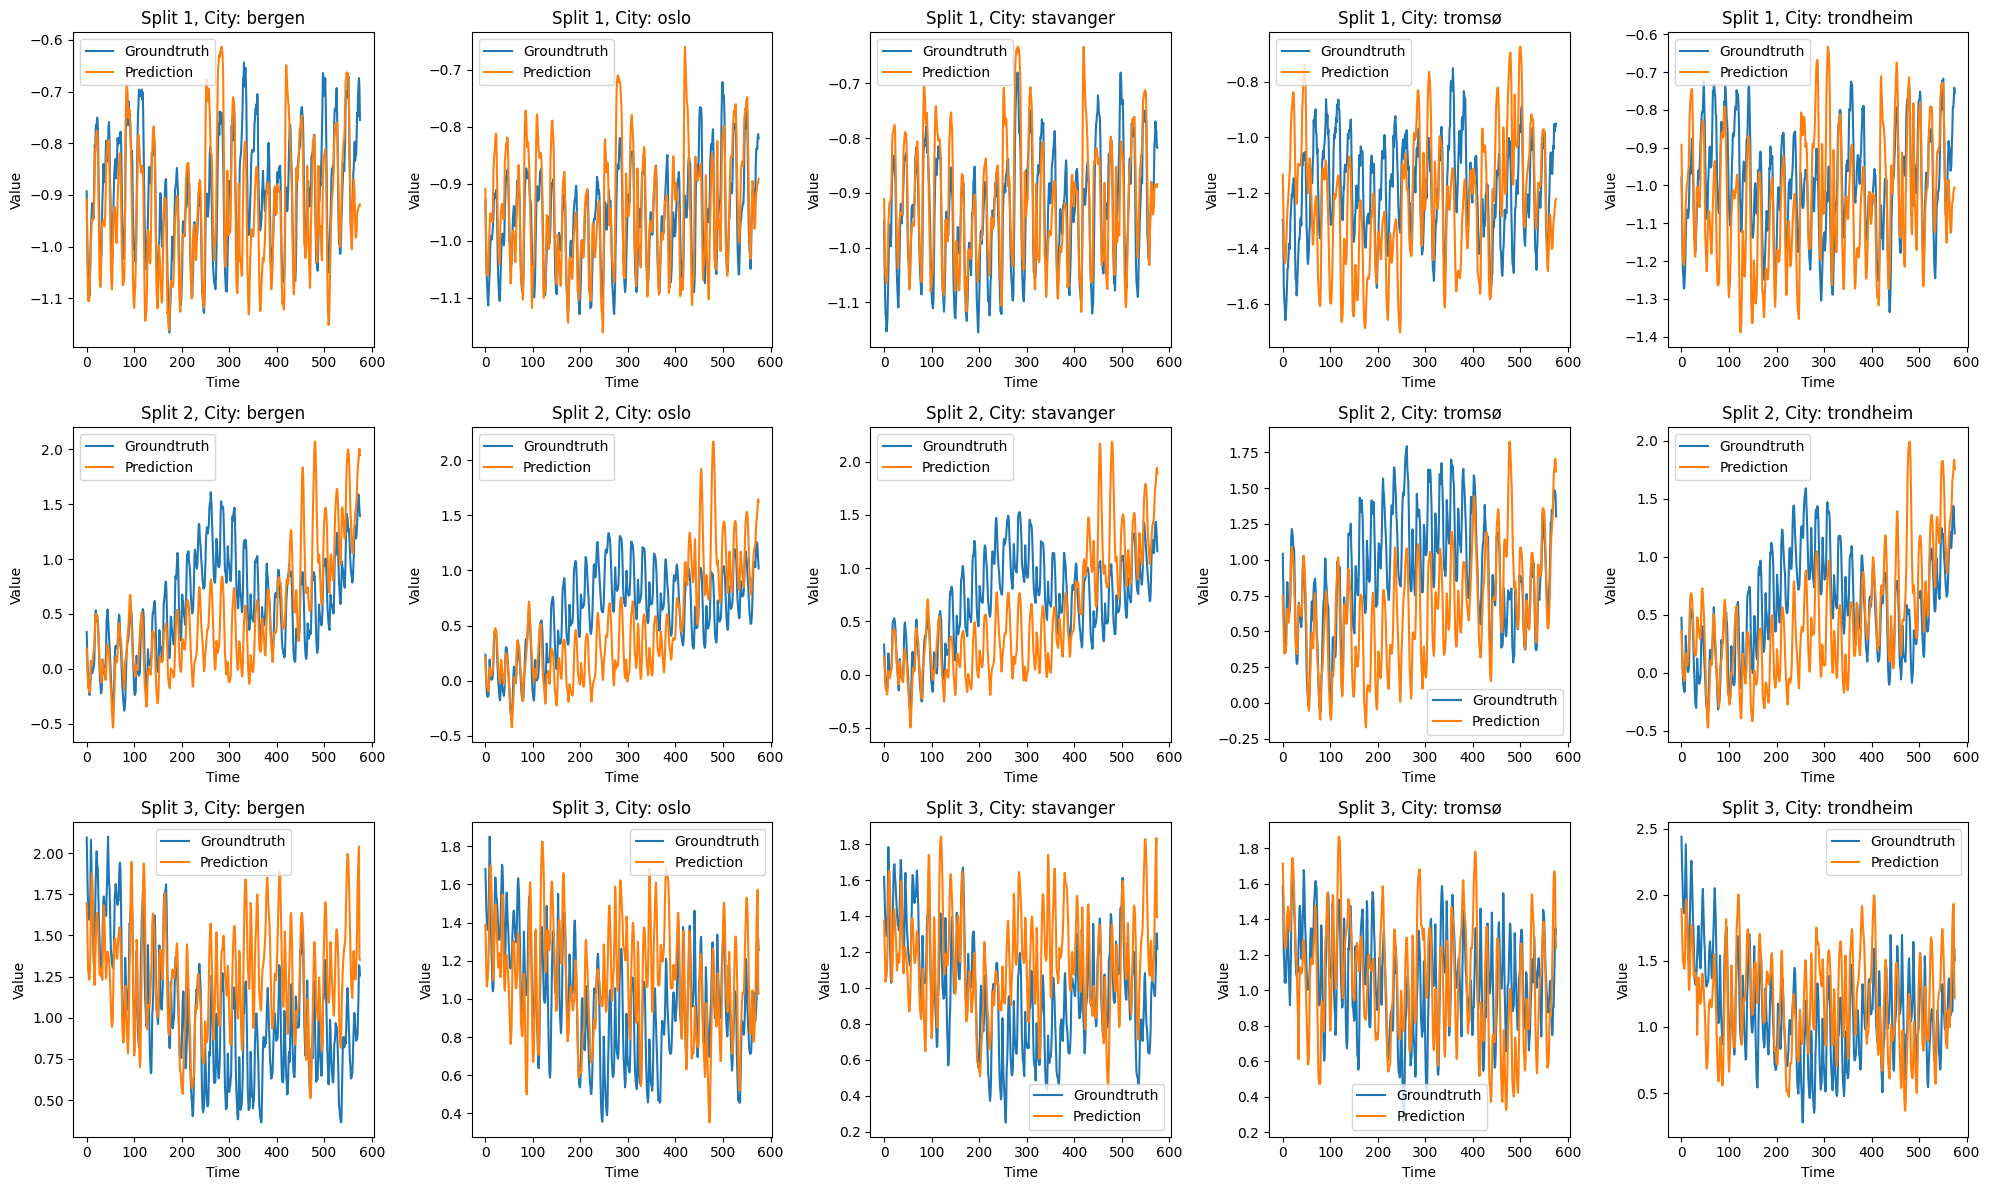

Metrics per City and Split:


Split  City       MAE       MSE      RMSE        MAPE
0       1     1  0.071195  0.008678  0.093153    8.333172
1       1     2  0.051162  0.004351  0.065962    5.421347
2       1     3  0.055153  0.004839  0.069562    6.039193
3       1     4  0.196654  0.050989  0.225808   17.159302
4       1     5  0.121056  0.021598  0.146964   12.474912
5       2     1  0.376327  0.218863  0.467828  187.601998
6       2     2  0.385794  0.218594  0.467540  161.453619
7       2     3  0.422891  0.268071  0.517756   82.132402
8       2     4  0.362388  0.210152  0.458424   44.507472
9       2     5  0.387103  0.230143  0.479732  169.848520
10      3     1  0.344638  0.172996  0.415928   43.272148
11      3     2  0.261290  0.105284  0.324474   32.070076
12      3     3  0.284864  0.128026  0.357808   36.610704
13      3     4  0.258652  0.098017  0.313077   27.056621
14      3     5  0.314285  0.138279  0.371858   33.144956


Average Metrics per City Across Splits:


City  Split       MAE       MSE      RMSE       MAPE
0     1    2.0  0.264053  0.133512  0.325637  79.735773
1     2    2.0  0.232749  0.109409  0.285992  66.315014
2     3    2.0  0.254303  0.133645  0.315042  41.594100
3     4    2.0  0.272565  0.119720  0.332436  29.574465
4     5    2.0  0.274148  0.130007  0.332852  71.822796


Overall Mean Metrics:
Mean MAE: 0.2595635769627915
Mean MSE: 0.1252587342134244
Mean RMSE: 0.31839170842748316
Mean MAPE: 57.80842957340776


In [217]:
visualize_and_get_metrics(splits=3, prediction=lstmall_preds, truth=xg_truths)

## Combine XG + Tuned Dual-LSTM

In [218]:
combined_preds = (lstmall_preds + xg_predictions) / 2

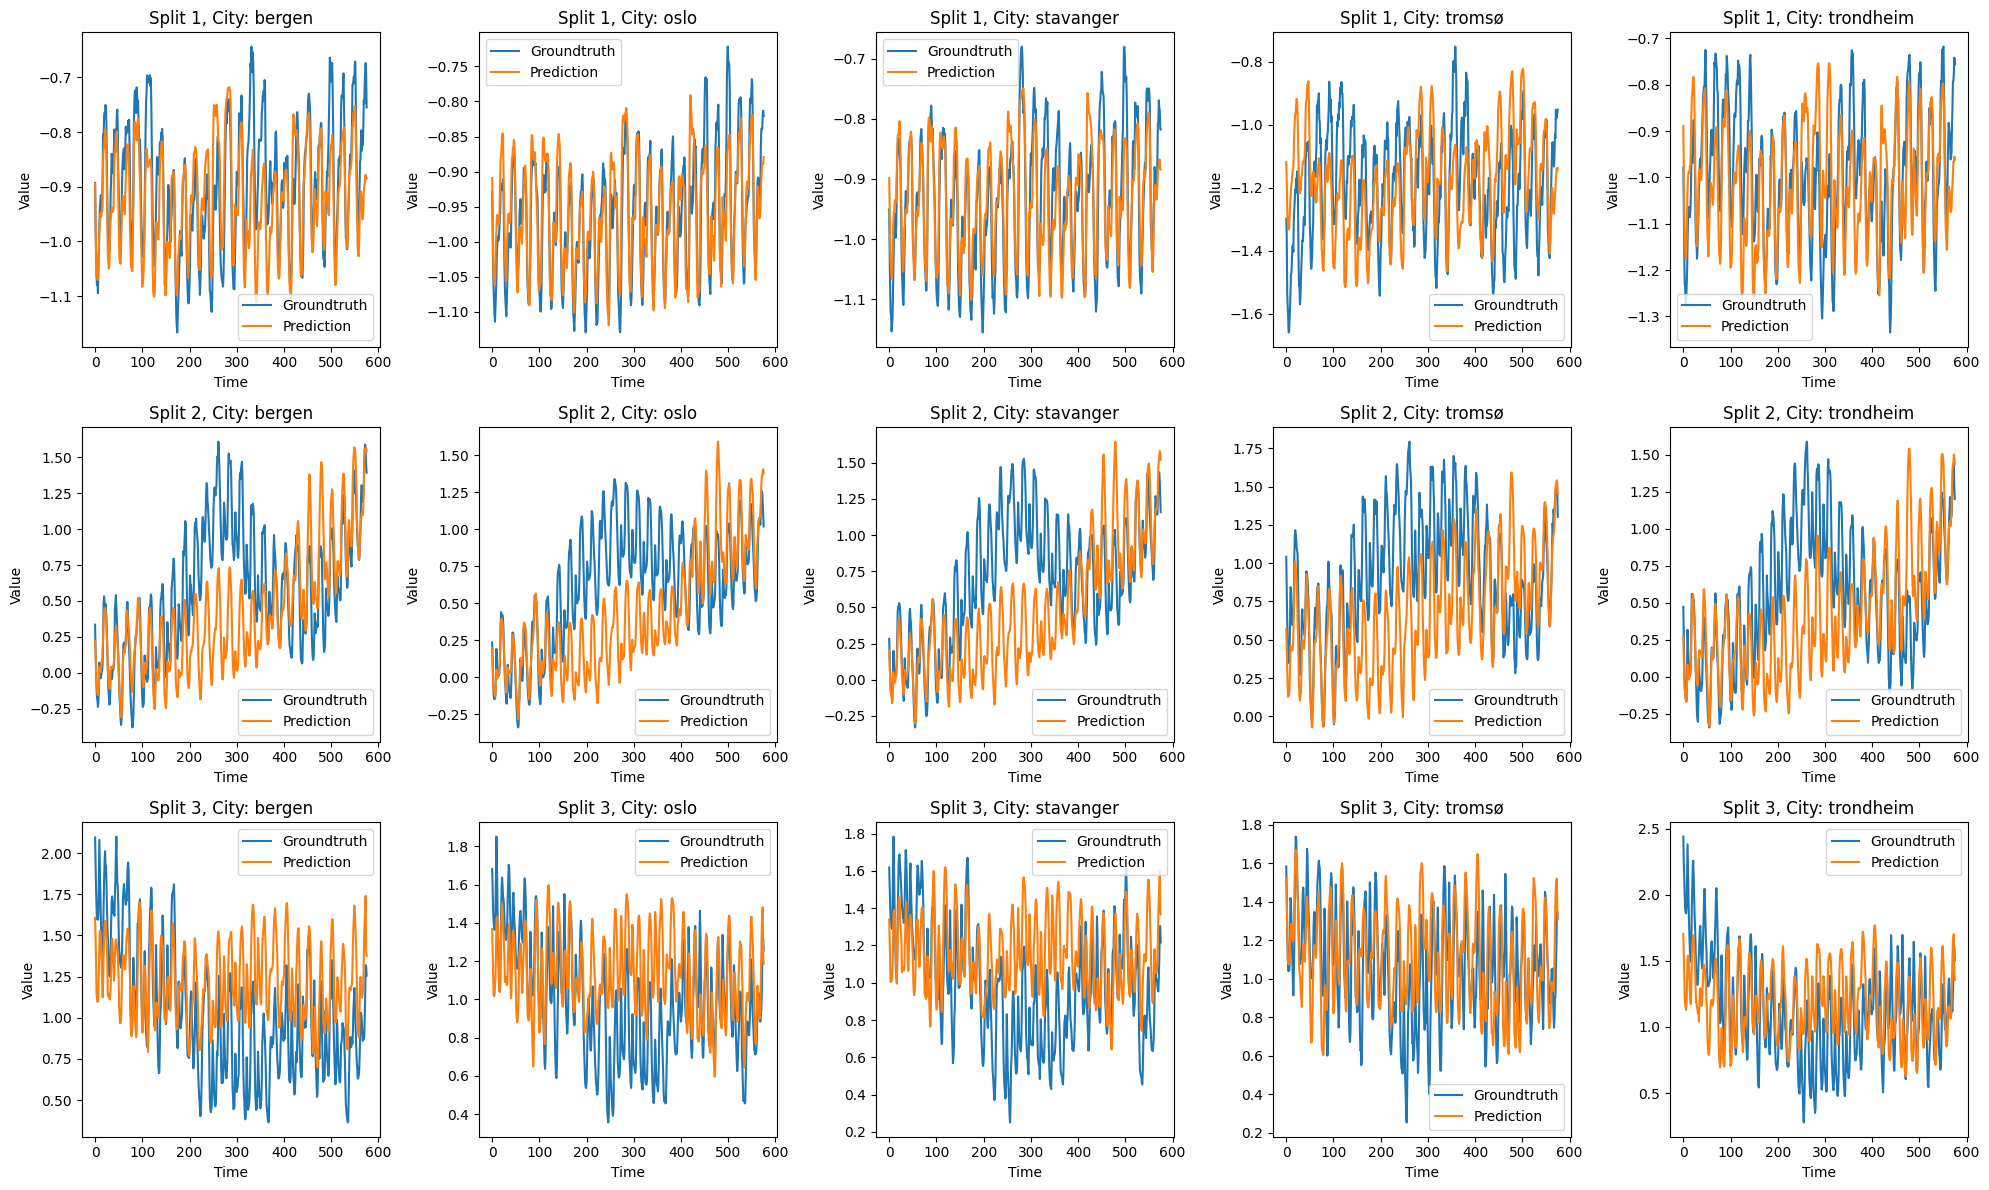

Metrics per City and Split:


Split  City       MAE       MSE      RMSE        MAPE
0       1     1  0.061613  0.006203  0.078760    7.291405
1       1     2  0.031860  0.001686  0.041062    3.403619
2       1     3  0.041223  0.002693  0.051893    4.548479
3       1     4  0.139012  0.026152  0.161715   12.009743
4       1     5  0.085457  0.010921  0.104503    8.904435
5       2     1  0.299652  0.164108  0.405103  119.716504
6       2     2  0.321154  0.163529  0.404388   86.893613
7       2     3  0.344901  0.199419  0.446564   66.436256
8       2     4  0.354070  0.184241  0.429233   41.833354
9       2     5  0.324581  0.175947  0.419460  138.437342
10      3     1  0.319022  0.137025  0.370168   40.352726
11      3     2  0.240955  0.087283  0.295437   30.519476
12      3     3  0.261148  0.102734  0.320522   34.479195
13      3     4  0.200425  0.059872  0.244688   22.308623
14      3     5  0.275052  0.110493  0.332405   29.267553


Average Metrics per City Across Splits:


City  Split       MAE       MSE      RMSE       MAPE
0     1    2.0  0.226763  0.102445  0.284677  55.786878
1     2    2.0  0.197990  0.084166  0.246962  40.272236
2     3    2.0  0.215757  0.101616  0.272993  35.154643
3     4    2.0  0.231169  0.090088  0.278545  25.383907
4     5    2.0  0.228363  0.099120  0.285456  58.869777


Overall Mean Metrics:
Mean MAE: 0.220008464498579
Mean MSE: 0.09548710284786915
Mean RMSE: 0.273726721999718
Mean MAPE: 43.09348820089587


In [219]:
visualize_and_get_metrics(splits=3, prediction=combined_preds, truth=xg_truths)

# Model 4: Transformer

## Tuned Transformer 1

### Create Model

In [220]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, 
                 feature_size=12, 
                 num_layers=1, 
                 num_heads=6, 
                 feedforward_dim=64, 
                 dropout=0.1, 
                 output_size=5,
                 pos_enc_size=216):
        super(TimeSeriesTransformer, self).__init__()
        
        self.feature_size = feature_size
        
        self.positional_encoding = nn.Parameter(torch.randn(1, pos_enc_size, feature_size))
        
        self.transformer = nn.Transformer(d_model=feature_size, 
                                          nhead=num_heads, 
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers, 
                                          dim_feedforward=feedforward_dim, 
                                          dropout=dropout)
        
        self.linear = nn.Linear(feature_size, output_size)
        
    def forward(self, x, verbose=False):
        # Add positional encoding
        x = x + self.positional_encoding

        if verbose:
            print('1:', x.shape)
        
        # Transformer expects tgt (target tensor) for supervised tasks, but for our forecasting task
        # We'll use shifted input as target (this is a common trick for time series forecasting)
        tgt = torch.roll(x, shifts=-1, dims=1)

        if verbose:
            print('2:', tgt.shape)
        
        # Apply transformer
        out = self.transformer(x, tgt)

        if verbose:
            print('3:', out.shape)
        
        # Use relevant steps from the transformer output
        out = out[:, :, :]

        if verbose:
            print('4:', out.shape)
        
        # Pass through linear layer
        out = self.linear(out)

        if verbose:
            print('5:', out.shape)
        
        return out
    
model = TimeSeriesTransformer()
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 8012
Trainable parameters: 8012


In [222]:
model = TimeSeriesTransformer()
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = torch.randn(25, 216, 12)
out = model(input, verbose=True)

1: torch.Size([25, 216, 12])
2: torch.Size([25, 216, 12])
3: torch.Size([25, 216, 12])
4: torch.Size([25, 216, 12])
5: torch.Size([25, 216, 12])


### Time series split trainer and loss

In [227]:
# Training loop
def train_model_transformer1_split_test(criterion, splits, epochs, lr=0.0003, batch_size=256, num_heads=6, dropout=0.1, feedforward_dim=64):

    tscv = TimeSeriesSplit(n_splits=splits)
    split_losses = []
    for train_index, val_index in tscv.split(train_X):
        X_train, X_val = train_X[train_index], train_X[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]

        lstm_model_test = TimeSeriesTransformer(feedforward_dim=feedforward_dim, dropout=dropout, num_heads=num_heads).to(device)
        train_dataset = TimeSeriesDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        lstm_optimizer_test = optim.Adam(lstm_model_test.parameters(), lr=lr)

        model.train()
        for epoch in range(epochs):
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                lstm_optimizer_test.zero_grad()
                outputs = lstm_model_test(batch_X)[:, :120, :5]
                loss = criterion(outputs, batch_y[:, :120, :5])
                loss.backward()
                lstm_optimizer_test.step()
            
            if (epoch + 1) % 2 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        model.eval()  # Set the model to evaluation mode
        val_dataset = TimeSeriesDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Batched Validation Loop
        total_val_loss = 0.0
        num_batches = 0
        with torch.no_grad():  # No need to track gradients during prediction
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                output_on_val = lstm_model_test(batch_X_val)[:, :120, :5]
                val_loss = criterion(output_on_val, batch_y_val[:, :120, :5])
                total_val_loss += val_loss.item()
                num_batches += 1

        average_val_loss = total_val_loss / num_batches
        print(f'Average Validation Loss: {average_val_loss:.4f}')
        split_losses.append(average_val_loss)

    return np.mean(split_losses)

mean_loss = train_model_transformer1_split_test(criterion, splits=3, epochs=30, feedforward_dim=64, lr=0.0003, batch_size=64)
print(f'Mean loss: {mean_loss}')

C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


Epoch [2/30], Loss: 0.4839
Epoch [4/30], Loss: 0.1171
Epoch [6/30], Loss: 0.0739
Epoch [8/30], Loss: 0.0725
Epoch [10/30], Loss: 0.0529
Epoch [12/30], Loss: 0.0542
Epoch [14/30], Loss: 0.0511
Epoch [16/30], Loss: 0.0438
Epoch [18/30], Loss: 0.0399
Epoch [20/30], Loss: 0.0394
Epoch [22/30], Loss: 0.0485
Epoch [24/30], Loss: 0.0425
Epoch [26/30], Loss: 0.0388
Epoch [28/30], Loss: 0.0451
Epoch [30/30], Loss: 0.0354
Average Validation Loss: 0.0613
Epoch [2/30], Loss: 0.1260
Epoch [4/30], Loss: 0.0715
Epoch [6/30], Loss: 0.0557
Epoch [8/30], Loss: 0.0584
Epoch [10/30], Loss: 0.0378
Epoch [12/30], Loss: 0.0546
Epoch [14/30], Loss: 0.0442
Epoch [16/30], Loss: 0.0450
Epoch [18/30], Loss: 0.0491
Epoch [20/30], Loss: 0.0418
Epoch [22/30], Loss: 0.0345
Epoch [24/30], Loss: 0.0327
Epoch [26/30], Loss: 0.0446
Epoch [28/30], Loss: 0.0353
Epoch [30/30], Loss: 0.0392
Average Validation Loss: 2.0262
Epoch [2/30], Loss: 0.2377
Epoch [4/30], Loss: 0.1989
Epoch [6/30], Loss: 0.1529
Epoch [8/30], Loss: 0.1

### Optuna Run

In [238]:
# Try to predict each city separately
criterion = nn.MSELoss()

# NB This can either be trained to predict the whole next sequence, or just for the hour in question.
# Did not see much difference in performance.

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    num_heads = trial.suggest_categorical("num_heads", [1, 2, 3, 4, 6, 12])
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    epochs = trial.suggest_int("epochs", 5, 50)

    # Model setup
    val_loss = train_model_transformer1_split_test(criterion, 3, epochs, lr=lr, batch_size=batch_size, num_heads=num_heads, dropout=dropout, feedforward_dim=hidden_size)

    # Return the metric to be optimized
    return val_loss

train_dataset = TimeSeriesDataset(train_X, train_y)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\539748728.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)
[I 2023-11-12 23:56:44,022] A new study created in memory with name: no-name-afbc3cfe-d3d1-43fc-bdcc-55906877b854


Epoch [2/45], Loss: 0.1946
Epoch [4/45], Loss: 0.0888
Epoch [6/45], Loss: 0.0664
Epoch [8/45], Loss: 0.0588
Epoch [10/45], Loss: 0.0555
Epoch [12/45], Loss: 0.0514
Epoch [14/45], Loss: 0.0477
Epoch [16/45], Loss: 0.0452
Epoch [18/45], Loss: 0.0432
Epoch [20/45], Loss: 0.0413
Epoch [22/45], Loss: 0.0402
Epoch [24/45], Loss: 0.0395
Epoch [26/45], Loss: 0.0380
Epoch [28/45], Loss: 0.0369
Epoch [30/45], Loss: 0.0362
Epoch [32/45], Loss: 0.0355
Epoch [34/45], Loss: 0.0353
Epoch [36/45], Loss: 0.0314
Epoch [38/45], Loss: 0.0339
Epoch [40/45], Loss: 0.0329
Epoch [42/45], Loss: 0.0319
Epoch [44/45], Loss: 0.0323
Average Validation Loss: 0.0529
Epoch [2/45], Loss: 0.0648
Epoch [4/45], Loss: 0.0582
Epoch [6/45], Loss: 0.0515
Epoch [8/45], Loss: 0.0469
Epoch [10/45], Loss: 0.0463
Epoch [12/45], Loss: 0.0396
Epoch [14/45], Loss: 0.0432
Epoch [16/45], Loss: 0.0409
Epoch [18/45], Loss: 0.0372
Epoch [20/45], Loss: 0.0346
Epoch [22/45], Loss: 0.0369
Epoch [24/45], Loss: 0.0344
Epoch [26/45], Loss: 0.0

[I 2023-11-13 00:03:26,567] Trial 0 finished with value: 0.9054608774474926 and parameters: {'lr': 0.0013492666370327209, 'batch_size': 256, 'hidden_size': 225, 'num_heads': 2, 'dropout': 0.2058464081359377, 'epochs': 45, 'out_shape': 7}. Best is trial 0 with value: 0.9054608774474926.


Average Validation Loss: 0.5135
Epoch [2/7], Loss: 1.1266
Epoch [4/7], Loss: 1.1055
Epoch [6/7], Loss: 1.0830
Average Validation Loss: 1.0292
Epoch [2/7], Loss: 0.9429
Epoch [4/7], Loss: 0.9197
Epoch [6/7], Loss: 0.8953
Average Validation Loss: 1.2791
Epoch [2/7], Loss: 1.6720
Epoch [4/7], Loss: 1.6807
Epoch [6/7], Loss: 1.6218


[I 2023-11-13 00:04:01,812] Trial 1 finished with value: 1.1697293983565435 and parameters: {'lr': 1.6691907949303564e-05, 'batch_size': 512, 'hidden_size': 98, 'num_heads': 1, 'dropout': 0.3205101831853283, 'epochs': 7, 'out_shape': 11}. Best is trial 0 with value: 0.9054608774474926.


Average Validation Loss: 1.2009
Epoch [2/34], Loss: 1.1117
Epoch [4/34], Loss: 1.1143
Epoch [6/34], Loss: 1.0301
Epoch [8/34], Loss: 1.0401
Epoch [10/34], Loss: 1.0138
Epoch [12/34], Loss: 0.9850
Epoch [14/34], Loss: 0.9939
Epoch [16/34], Loss: 0.9144
Epoch [18/34], Loss: 0.8859
Epoch [20/34], Loss: 0.8834
Epoch [22/34], Loss: 0.8737
Epoch [24/34], Loss: 0.8371
Epoch [26/34], Loss: 0.8032
Epoch [28/34], Loss: 0.7871
Epoch [30/34], Loss: 0.7876
Epoch [32/34], Loss: 0.7737
Epoch [34/34], Loss: 0.7219
Average Validation Loss: 0.7754
Epoch [2/34], Loss: 1.2785
Epoch [4/34], Loss: 1.1800
Epoch [6/34], Loss: 1.1176
Epoch [8/34], Loss: 0.9547
Epoch [10/34], Loss: 0.8896
Epoch [12/34], Loss: 0.7811
Epoch [14/34], Loss: 0.8208
Epoch [16/34], Loss: 0.7796
Epoch [18/34], Loss: 0.6436
Epoch [20/34], Loss: 0.6626
Epoch [22/34], Loss: 0.5484
Epoch [24/34], Loss: 0.5486
Epoch [26/34], Loss: 0.4323
Epoch [28/34], Loss: 0.4532
Epoch [30/34], Loss: 0.4050
Epoch [32/34], Loss: 0.3830
Epoch [34/34], Loss:

[I 2023-11-13 00:12:48,567] Trial 2 finished with value: 1.3894868397878275 and parameters: {'lr': 9.07061467764281e-06, 'batch_size': 128, 'hidden_size': 180, 'num_heads': 2, 'dropout': 0.0891614698398045, 'epochs': 34, 'out_shape': 6}. Best is trial 0 with value: 0.9054608774474926.


Average Validation Loss: 2.0885
Epoch [2/45], Loss: 2.1934
Epoch [4/45], Loss: 2.0931
Epoch [6/45], Loss: 2.0799
Epoch [8/45], Loss: 1.9939
Epoch [10/45], Loss: 1.9501
Epoch [12/45], Loss: 1.9063
Epoch [14/45], Loss: 1.8165
Epoch [16/45], Loss: 1.7977
Epoch [18/45], Loss: 1.6781
Epoch [20/45], Loss: 1.6282
Epoch [22/45], Loss: 1.5547
Epoch [24/45], Loss: 1.4919
Epoch [26/45], Loss: 1.4389
Epoch [28/45], Loss: 1.3922
Epoch [30/45], Loss: 1.2670
Epoch [32/45], Loss: 1.2471
Epoch [34/45], Loss: 1.1861
Epoch [36/45], Loss: 1.0817
Epoch [38/45], Loss: 1.0470
Epoch [40/45], Loss: 0.9789
Epoch [42/45], Loss: 0.9318
Epoch [44/45], Loss: 0.8920
Average Validation Loss: 0.8291
Epoch [2/45], Loss: 0.9510
Epoch [4/45], Loss: 0.6328
Epoch [6/45], Loss: 0.5749
Epoch [8/45], Loss: 0.5400
Epoch [10/45], Loss: 0.5560
Epoch [12/45], Loss: 0.4358
Epoch [14/45], Loss: 0.4473
Epoch [16/45], Loss: 0.4231
Epoch [18/45], Loss: 0.3993
Epoch [20/45], Loss: 0.3045
Epoch [22/45], Loss: 0.3242
Epoch [24/45], Loss:

[I 2023-11-13 00:21:13,709] Trial 3 finished with value: 1.6350616994831295 and parameters: {'lr': 1.9470538182967885e-05, 'batch_size': 128, 'hidden_size': 144, 'num_heads': 3, 'dropout': 0.11088960748050375, 'epochs': 45, 'out_shape': 7}. Best is trial 0 with value: 0.9054608774474926.


Average Validation Loss: 2.3939
Epoch [2/21], Loss: 1.8614
Epoch [4/21], Loss: 1.8229
Epoch [6/21], Loss: 1.8259
Epoch [8/21], Loss: 1.8070
Epoch [10/21], Loss: 1.8095
Epoch [12/21], Loss: 1.7992
Epoch [14/21], Loss: 1.7948
Epoch [16/21], Loss: 1.7651
Epoch [18/21], Loss: 1.7570
Epoch [20/21], Loss: 1.7654
Average Validation Loss: 1.7536
Epoch [2/21], Loss: 0.9388
Epoch [4/21], Loss: 0.9317
Epoch [6/21], Loss: 0.9227
Epoch [8/21], Loss: 0.8984
Epoch [10/21], Loss: 0.8907
Epoch [12/21], Loss: 0.8876
Epoch [14/21], Loss: 0.8718
Epoch [16/21], Loss: 0.8565
Epoch [18/21], Loss: 0.8447
Epoch [20/21], Loss: 0.8331
Average Validation Loss: 1.0803
Epoch [2/21], Loss: 1.3318
Epoch [4/21], Loss: 1.2998
Epoch [6/21], Loss: 1.2641
Epoch [8/21], Loss: 1.2350
Epoch [10/21], Loss: 1.2176
Epoch [12/21], Loss: 1.2054
Epoch [14/21], Loss: 1.1908
Epoch [16/21], Loss: 1.1627
Epoch [18/21], Loss: 1.1169
Epoch [20/21], Loss: 1.1545


[I 2023-11-13 00:29:29,471] Trial 4 finished with value: 1.4400835732618968 and parameters: {'lr': 9.730126557418562e-06, 'batch_size': 512, 'hidden_size': 123, 'num_heads': 2, 'dropout': 0.08145924852941518, 'epochs': 21, 'out_shape': 7}. Best is trial 0 with value: 0.9054608774474926.


Average Validation Loss: 1.4863
Epoch [2/14], Loss: 0.2042
Epoch [4/14], Loss: 0.0997
Epoch [6/14], Loss: 0.0726
Epoch [8/14], Loss: 0.0681
Epoch [10/14], Loss: 0.0634
Epoch [12/14], Loss: 0.0581
Epoch [14/14], Loss: 0.0547
Average Validation Loss: 0.0785
Epoch [2/14], Loss: 0.1801
Epoch [4/14], Loss: 0.0726
Epoch [6/14], Loss: 0.0639
Epoch [8/14], Loss: 0.0566
Epoch [10/14], Loss: 0.0548
Epoch [12/14], Loss: 0.0516
Epoch [14/14], Loss: 0.0520
Average Validation Loss: 2.1989
Epoch [2/14], Loss: 0.4926
Epoch [4/14], Loss: 0.2391
Epoch [6/14], Loss: 0.1718
Epoch [8/14], Loss: 0.1411
Epoch [10/14], Loss: 0.1318
Epoch [12/14], Loss: 0.1158


[I 2023-11-13 00:31:10,470] Trial 5 finished with value: 1.5318247849742572 and parameters: {'lr': 0.0022900130982609645, 'batch_size': 512, 'hidden_size': 243, 'num_heads': 1, 'dropout': 0.21970327792521888, 'epochs': 14, 'out_shape': 6}. Best is trial 0 with value: 0.9054608774474926.


Epoch [14/14], Loss: 0.0992
Average Validation Loss: 2.3180
Epoch [2/40], Loss: 0.4753
Epoch [4/40], Loss: 0.3041
Epoch [6/40], Loss: 0.2105
Epoch [8/40], Loss: 0.1592
Epoch [10/40], Loss: 0.1293
Epoch [12/40], Loss: 0.1114
Epoch [14/40], Loss: 0.0998
Epoch [16/40], Loss: 0.0929
Epoch [18/40], Loss: 0.0866
Epoch [20/40], Loss: 0.0822
Epoch [22/40], Loss: 0.0785
Epoch [24/40], Loss: 0.0757
Epoch [26/40], Loss: 0.0726
Epoch [28/40], Loss: 0.0694
Epoch [30/40], Loss: 0.0677
Epoch [32/40], Loss: 0.0650
Epoch [34/40], Loss: 0.0634
Epoch [36/40], Loss: 0.0622
Epoch [38/40], Loss: 0.0604
Epoch [40/40], Loss: 0.0590
Average Validation Loss: 0.0806
Epoch [2/40], Loss: 0.7156
Epoch [4/40], Loss: 0.4208
Epoch [6/40], Loss: 0.2566
Epoch [8/40], Loss: 0.1788
Epoch [10/40], Loss: 0.1374
Epoch [12/40], Loss: 0.1143
Epoch [14/40], Loss: 0.1002
Epoch [16/40], Loss: 0.0921
Epoch [18/40], Loss: 0.0840
Epoch [20/40], Loss: 0.0813
Epoch [22/40], Loss: 0.0773
Epoch [24/40], Loss: 0.0761
Epoch [26/40], Loss:

[I 2023-11-13 00:52:17,706] Trial 6 finished with value: 1.1572207572559516 and parameters: {'lr': 0.0007343278109788073, 'batch_size': 512, 'hidden_size': 60, 'num_heads': 3, 'dropout': 0.29481506222320486, 'epochs': 40, 'out_shape': 11}. Best is trial 0 with value: 0.9054608774474926.


Average Validation Loss: 1.3224
Epoch [2/9], Loss: 0.2551
Epoch [4/9], Loss: 0.0898
Epoch [6/9], Loss: 0.0524
Epoch [8/9], Loss: 0.0516
Average Validation Loss: 0.0883
Epoch [2/9], Loss: 0.0998
Epoch [4/9], Loss: 0.0629
Epoch [6/9], Loss: 0.0588
Epoch [8/9], Loss: 0.0527
Average Validation Loss: 2.2484
Epoch [2/9], Loss: 0.4371
Epoch [4/9], Loss: 0.1936
Epoch [6/9], Loss: 0.1352
Epoch [8/9], Loss: 0.1048


[I 2023-11-13 01:04:59,733] Trial 7 finished with value: 0.9793872932593027 and parameters: {'lr': 0.0034667470045941164, 'batch_size': 512, 'hidden_size': 125, 'num_heads': 4, 'dropout': 0.09197391828099546, 'epochs': 9, 'out_shape': 5}. Best is trial 0 with value: 0.9054608774474926.


Average Validation Loss: 0.6014
Epoch [2/34], Loss: 0.0767
Epoch [4/34], Loss: 0.0637
Epoch [6/34], Loss: 0.0448
Epoch [8/34], Loss: 0.0437
Epoch [10/34], Loss: 0.0367
Epoch [12/34], Loss: 0.0358
Epoch [14/34], Loss: 0.0362
Epoch [16/34], Loss: 0.0337
Epoch [18/34], Loss: 0.0331
Epoch [20/34], Loss: 0.0323
Epoch [22/34], Loss: 0.0313
Epoch [24/34], Loss: 0.0312
Epoch [26/34], Loss: 0.0302
Epoch [28/34], Loss: 0.0309
Epoch [30/34], Loss: 0.0287
Epoch [32/34], Loss: 0.0286
Epoch [34/34], Loss: 0.0279
Average Validation Loss: 0.0514
Epoch [2/34], Loss: 0.0649
Epoch [4/34], Loss: 0.0466
Epoch [6/34], Loss: 0.0404
Epoch [8/34], Loss: 0.0396
Epoch [10/34], Loss: 0.0372
Epoch [12/34], Loss: 0.0355
Epoch [14/34], Loss: 0.0365
Epoch [16/34], Loss: 0.0332
Epoch [18/34], Loss: 0.0326
Epoch [20/34], Loss: 0.0320
Epoch [22/34], Loss: 0.0336
Epoch [24/34], Loss: 0.0314
Epoch [26/34], Loss: 0.0301
Epoch [28/34], Loss: 0.0296
Epoch [30/34], Loss: 0.0276
Epoch [32/34], Loss: 0.0297
Epoch [34/34], Loss:

[W 2023-11-13 01:42:55,974] Trial 8 failed with parameters: {'lr': 0.009742669718224654, 'batch_size': 512, 'hidden_size': 50, 'num_heads': 6, 'dropout': 0.02377429316319888, 'epochs': 34, 'out_shape': 10} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 1.27 GiB (GPU 0; 8.00 GiB total capacity; 10.29 GiB already allocated; 0 bytes free; 12.83 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "c:\Users\Ferdinand\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Ferdinand\AppData\Local\Temp\ipykernel_15712\1798791330.py", line 18, in objective
    val_loss = train_model_transformer1_split_test(criterion, 3, epochs, 

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.27 GiB (GPU 0; 8.00 GiB total capacity; 10.29 GiB already allocated; 0 bytes free; 12.83 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:


NameError: name 'study' is not defined

### Train with tuned parameters

In [ ]:
# Try to predict each city separately
criterion = nn.MSELoss()
lr = 0.0003
batch_size = 256
epochs = 50
# lr = 0.0005
# batch_size = 128
# epochs = 20

# NB This can either be trained to predict the whole next sequence, or just for the hour in question.
# Did not see much difference in performance.

# Training loop
def train_model_lstm1(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)[:, 119, :5]
            # print(outputs.shape)
            # print(batch_y.shape)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the models
lstm_model1 = TimeSeriesLSTMMulti(hidden_size=128, output_size=5).to(device)
# print(train_y.shape)
train_dataset = TimeSeriesDataset(train_X, train_y[:, 119, :5])
# Instantiate data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lstm_optimizer1 = optim.Adam(lstm_model1.parameters(), lr=lr)
train_model_lstm1(lstm_model1, train_loader, criterion, lstm_optimizer1, epochs=epochs)

### Get Predictions

### Output results

## Tuned Transformer 2

In [ ]:
class TransformerForecasting(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, output_dim, n_future):
        super(TransformerForecasting, self).__init__()

        # Embedding layer: This layer converts the input features into embeddings of dimension d_model
        self.embedding = nn.Linear(input_dim, d_model)

        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead),
            num_layers=num_encoder_layers
        )

        # Output layer: Produces a vector for future time steps
        self.output_layer = nn.Linear(d_model, output_dim * n_future)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.output_layer(x[:, -1, :])  # Only consider the last time step's output for forecasting
        return x.view(x.size(0), -1)

## Tuned Dual-Transformer

In [ ]:
# Try to predict each city separately
criterion = nn.MSELoss()
lr = 0.0003
batch_size = 256
epochs = 50

# NB This can either be trained to predict the whole next sequence, or just for the hour in question.
# Did not see much difference in performance.

# Training loop
def train_model_transformer1(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            # print('x',batch_X.shape)
            # print('y',batch_y.shape)
            consumption_inputs = batch_X[:, :, :5]
            # print(consumption_inputs.shape)
            rest_inputs = torch.cat((batch_X[:, :, 5:], batch_y[:, :, 5:]), 1)
            # print(rest_inputs.shape)
            outputs = model(consumption_inputs,rest_inputs)[:, :120, :]
            # print('o',outputs.shape)
            # print('by',batch_y.shape)
            loss = criterion(outputs, batch_y[:, :120, :5])
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the models
lstm_model2 = DualInputLSTM(5, 7, 64, 5).to(device)
# print(train_y.shape)
train_dataset = TimeSeriesDataset(train_X, train_y)
# Instantiate data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lstm_optimizer2 = optim.Adam(lstm_model2.parameters(), lr=lr)
train_model_lstm_dual(lstm_model2, train_loader, criterion, lstm_optimizer2, epochs=epochs)